This is a notebook used to process and plot data from Del Vecchio et al "Hillslope-channel coupling in a changing permafrost landscape: the critical role of water tracks "

# Import packages

In [1]:
import os
import rasterio
from rasterio.plot import show
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.colors as colors
from scipy.stats import binned_statistic

from osgeo import gdal, ogr, osr

import shapely.geometry

import seaborn as sns

import rioxarray as rxr
import xarray
import pandas as pd

from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib import colors



%matplotlib inline

In [2]:
# To do
# from statannotations.Annotator import Annotator

In [2]:
basic_stack_dir = "./basic_stack_dir/"

# Create rasters for the "stack" with downscaled DEM (run once)

## Resample ArcticDEM

The 2 m resolution was important when we ran LSDTT, but we're going to coarsen it to eliminate microtopography

In [ ]:
elev_raster_path = "./basic_stack_dir/seward2_hsp_elev.tif"

from contextlib import contextmanager  

import rasterio
from rasterio import Affine, MemoryFile
from rasterio.enums import Resampling

# use context manager so DatasetReader and MemoryFile get cleaned up automatically
@contextmanager
def resample_raster(raster, target_res=15):
    t = raster.transform

    # rescale the metadata
    scale = t[0]/target_res
    transform = Affine(t.a / scale, t.b, t.c, t.d, t.e / scale, t.f)
    height = int(raster.height * scale)
    width = int(raster.width * scale)

    profile = raster.profile
    profile.update(transform=transform, driver='GTiff', height=height, width=width)

    data = raster.read( # Note changed order of indexes, arrays are band, row, col order not row, col, band
            out_shape=(raster.count, height, width),
            resampling=Resampling.cubic,
        )

    with MemoryFile() as memfile:
        with memfile.open(**profile) as dataset: # Open as DatasetWriter
            dataset.write(data)                     
            del data

        with memfile.open() as dataset:  # Reopen as DatasetReader
            yield dataset  # Note yield not return     


with rasterio.open(elev_raster_path) as src:
    with resample_raster(src) as resampled:
        print('Orig dims: {}, New dims: {}'.format(src.shape, resampled.shape))
        print(repr(resampled))
        out_meta = resampled.meta.copy()
        with rasterio.open(("15m_dem.tif"),"w",**out_meta) as dest:
            dest.write(resampled.read(1),1)
       

        
        
#https://gis.stackexchange.com/questions/329434/creating-an-in-memory-rasterio-dataset-from-numpy-array/329439#329439
#with edits by me to turn height and width to integer if you want to downscale
#and automated scaling after providing desired output resolution (a little more intuitive)

In [ ]:
def resample_raster(raster, target_res=40):
    t = raster.transform

    # rescale the metadata
    scale = t[0]/target_res
    transform = Affine(t.a / scale, t.b, t.c, t.d, t.e / scale, t.f)
    height = int(raster.height * scale)
    width = int(raster.width * scale)

    profile = raster.profile
    profile.update(transform=transform, driver='GTiff', height=height, width=width)

    data = raster.read( # Note changed order of indexes, arrays are band, row, col order not row, col, band
            out_shape=(raster.count, height, width),
            resampling=Resampling.cubic,
        )

    with MemoryFile() as memfile:
        with memfile.open(**profile) as dataset: # Open as DatasetWriter
            dataset.write(data)                     
            del data

        with memfile.open() as dataset:  # Reopen as DatasetReader
            yield dataset  # Note yield not return     


with rasterio.open(elev_raster_path) as src:
    with resample_raster(src) as resampled:
        print('Orig dims: {}, New dims: {}'.format(src.shape, resampled.shape))
        print(repr(resampled))
        out_meta = resampled.meta.copy()
        with rasterio.open(("40m_dem.tif"),"w",**out_meta) as dest:
            dest.write(resampled.read(1),1)
       

        
        
#https://gis.stackexchange.com/questions/329434/creating-an-in-memory-rasterio-dataset-from-numpy-array/329439#329439
#with edits by me to turn height and width to integer if you want to downscale
#and automated scaling after providing desired output resolution (a little more intuitive)

## Use RichDEM to calculate slope and aspect and send to stack directory

In [ ]:
import richdem as rd

new_raster_path = "./15m_dem.tif"

elev  = rd.LoadGDAL(new_raster_path)
slope = rd.TerrainAttribute(elev, attrib='slope_riserun')
aspect = rd.TerrainAttribute(elev, attrib='aspect')

with rasterio.open((os.path.join(basic_stack_dir, "slope_15m.tif")),"w",**out_meta) as dest:
    dest.write(slope, 1) #https://gis.stackexchange.com/questions/279953/numpy-array-to-gtiff-using-rasterio-without-source-raster
with rasterio.open((os.path.join(basic_stack_dir, "aspect_15m.tif")),"w",**out_meta) as dest:
    dest.write(aspect, 1)


I really need to resample aspect to be 40 m *and* align grid cells with the InSAR raster like in GDAL but this will do the job for now (or get Simon to send his apsect raster, which I think he has)

In [ ]:
new_raster_path = "./40m_dem.tif"

elev  = rd.LoadGDAL(new_raster_path)
slope = rd.TerrainAttribute(elev, attrib='slope_riserun')
aspect = rd.TerrainAttribute(elev, attrib='aspect')

with rasterio.open((os.path.join(basic_stack_dir, "slope_40m.tif")),"w",**out_meta) as dest:
    dest.write(slope, 1) #https://gis.stackexchange.com/questions/279953/numpy-array-to-gtiff-using-rasterio-without-source-raster
with rasterio.open((os.path.join(basic_stack_dir, "aspect_40m.tif")),"w",**out_meta) as dest:
    dest.write(aspect, 1)

# Sample hillslope transects along the raster stack

I'll admit: I traced these transects in ArcMaP,

but this profile is superior to Arcs!

In [3]:
def extract_along_line(xarr, xarr_string, line, crs, resolution):
    x=[]
    y=[]
    profile = []
    
    line_length = line.length
    n_samples= int(round(line_length/resolution))

    for i in range(n_samples):
        # get next point on the line
        point = line.interpolate(i / n_samples - 1., normalized=True)
        # access the nearest pixel in the xarray
        value = xarr.sel(x=point.x, y=point.y, method="nearest").data
        
        x.append(point.x)
        y.append(point.y)
        profile.append(value)
        
    df = pd.DataFrame({'x':x, 'y':y, xarr_string : np.asarray(profile)})
    
    gdf = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df.x, df.y),
        crs=crs
                          )
    
    gdf['distance_between'] = gdf.distance(gdf.shift(1))
    gdf['distance'] = gdf['distance_between'].cumsum()
    return gdf

# based on https://stackoverflow.com/questions/62283718/how-to-extract-a-profile-of-value-from-a-raster-along-a-given-line

In [4]:
profiles = gpd.read_file('hillslope_transects.shp')

In [5]:
profiles['Name'] = profiles.index.values.astype(str)

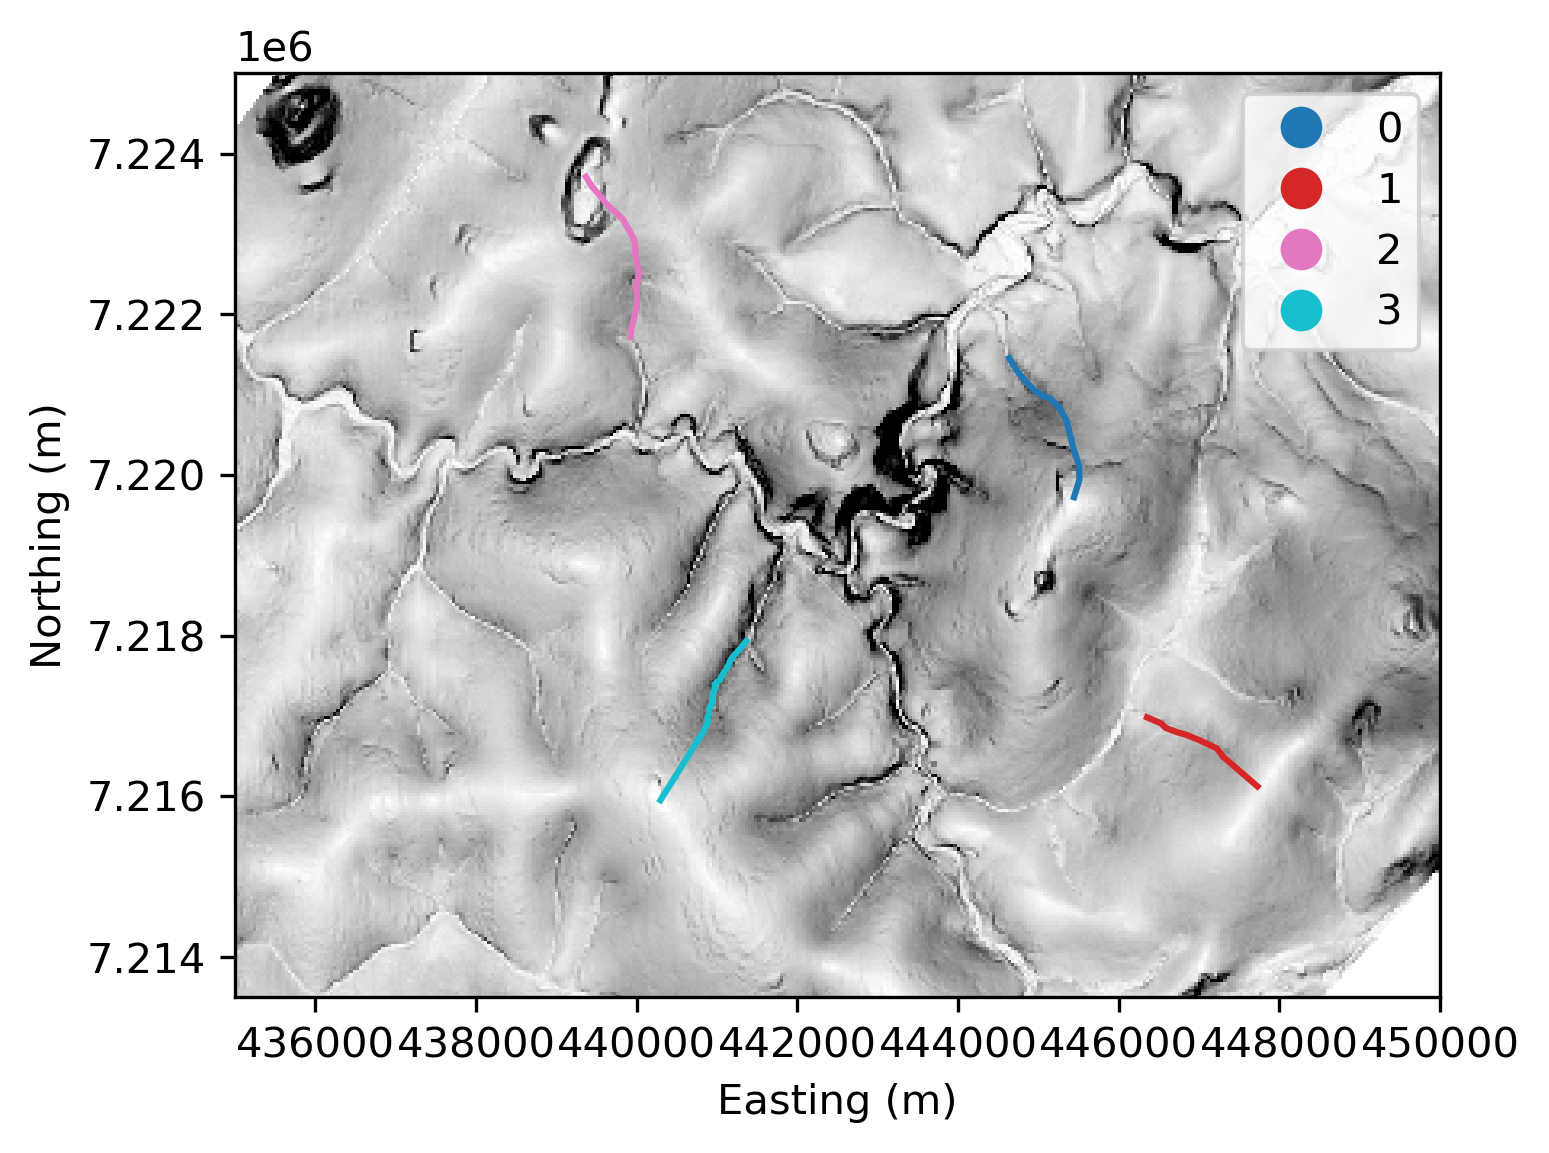

In [6]:
slopeshade = rasterio.open((os.path.join(basic_stack_dir,'slope_15m.tif')), masked=True)
# slope_read = slopeshade.read(1, masked=True)

# extent=[slope_read.bounds[0], slope_read.bounds[2], slope_read.bounds[1], slope_read.bounds[3]]


fig, ax = plt.subplots(figsize=(5,5),dpi=300)
slope = rasterio.plot.show(slopeshade, vmin=0.0, vmax=0.4, cmap='binary',  ax=ax, zorder=0)
profs = profiles.plot(ax=ax,
                      column="Name",
                      legend=True,
                      # legend_kwds={
                      # 'label': "Profile",
                      #   # 'orientation': "horizontal"
                      #                                                  }
                      # extent=extent
                     )
# basins = gpd_polygonized_raster.plot(column='disp_zscor',cmap='magma',
#                                      vmax=2,
#                                      vmin=-2,
#                                      alpha=0.5,
#                                      ax=ax,
#                                      zorder=1,
#                                      legend=True, 
#                                      legend_kwds={'label': "Basin-averaged displacement z-score",
#                         'orientation': "horizontal"})
ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')
# ax.legend(title="Profile")

fig.tight_layout()

ax.set_ylim((7.2135e6, 7.225e6))
ax.set_xlim((435000, 450000))

plt.savefig(('./figure_outputs/hillslope_transects_map.png'), bbox_inches="tight")

In [94]:
elev_raster_path = "./basic_stack_dir/seward2_hsp_elev.tif"
insar_raster_path = "./basic_stack_dir/insar_displacement.tif"
curv_raster_path = "./basic_stack_dir/seward_hsp__tan_curv_LW.tif"

# Load xarray
elevation = rxr.open_rasterio(elev_raster_path).squeeze()
insar = rxr.open_rasterio(insar_raster_path).squeeze()
curv = rxr.open_rasterio(curv_raster_path).squeeze()

#line = profiles_interp

extracted_elev = {}
extracted_insar = {}
extracted_curv = {}


for i in profiles.index:
    extracted_elev[i]= extract_along_line(elevation, 'elevation', profiles.loc[i, 'geometry'], crs=profiles.crs, resolution=2)
    extracted_insar[i]= extract_along_line(insar, 'insar', profiles.loc[i, 'geometry'], crs=profiles.crs, resolution=2).rolling(20).mean()
    extracted_curv[i]= extract_along_line(curv, 'curv', profiles.loc[i, 'geometry'], crs=profiles.crs, resolution=2).rolling(20).mean()


/scratch/ipykernel_19078/2162958678.py:19: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['geometry'], dtype='object')
  extracted_insar[i]= extract_along_line(insar, 'insar', profiles.loc[i, 'geometry'], crs=profiles.crs, resolution=2).rolling(20).mean()
/scratch/ipykernel_19078/2162958678.py:20: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['geometry'], dtype='object')
  extracted_curv[i]= extract_along_line(curv, 'curv', profiles.loc[i, 'geometry'], crs=profiles.crs, resolution=2).rolling(20).mean()
/scratch/ipykernel_19078/2162958678.py:19: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise T

To do: add code that loops through stack like landscape-wide code

In [106]:
elev_df = pd.concat(extracted_elev, axis=0).reset_index(level=0).rename({'level_0':'profile'}, axis=1).reset_index()
insar_df = pd.concat(extracted_insar, axis=0).reset_index(level=0).rename({'level_0':'profile'}, axis=1).reset_index()
curv_df = pd.concat(extracted_curv, axis=0).reset_index(level=0).rename({'level_0':'profile'}, axis=1).reset_index()
multiprofile_df = elev_df.join(insar_df['insar']).join(curv_df['curv'])

# # Reduce noise with a rolling mean
# multiprofile_df['insar_rolling'] = multiprofile_df['insar'].rolling(20).mean()
# multiprofile_df['curv_rolling'] = multiprofile_df['curv'].rolling(20).mean()

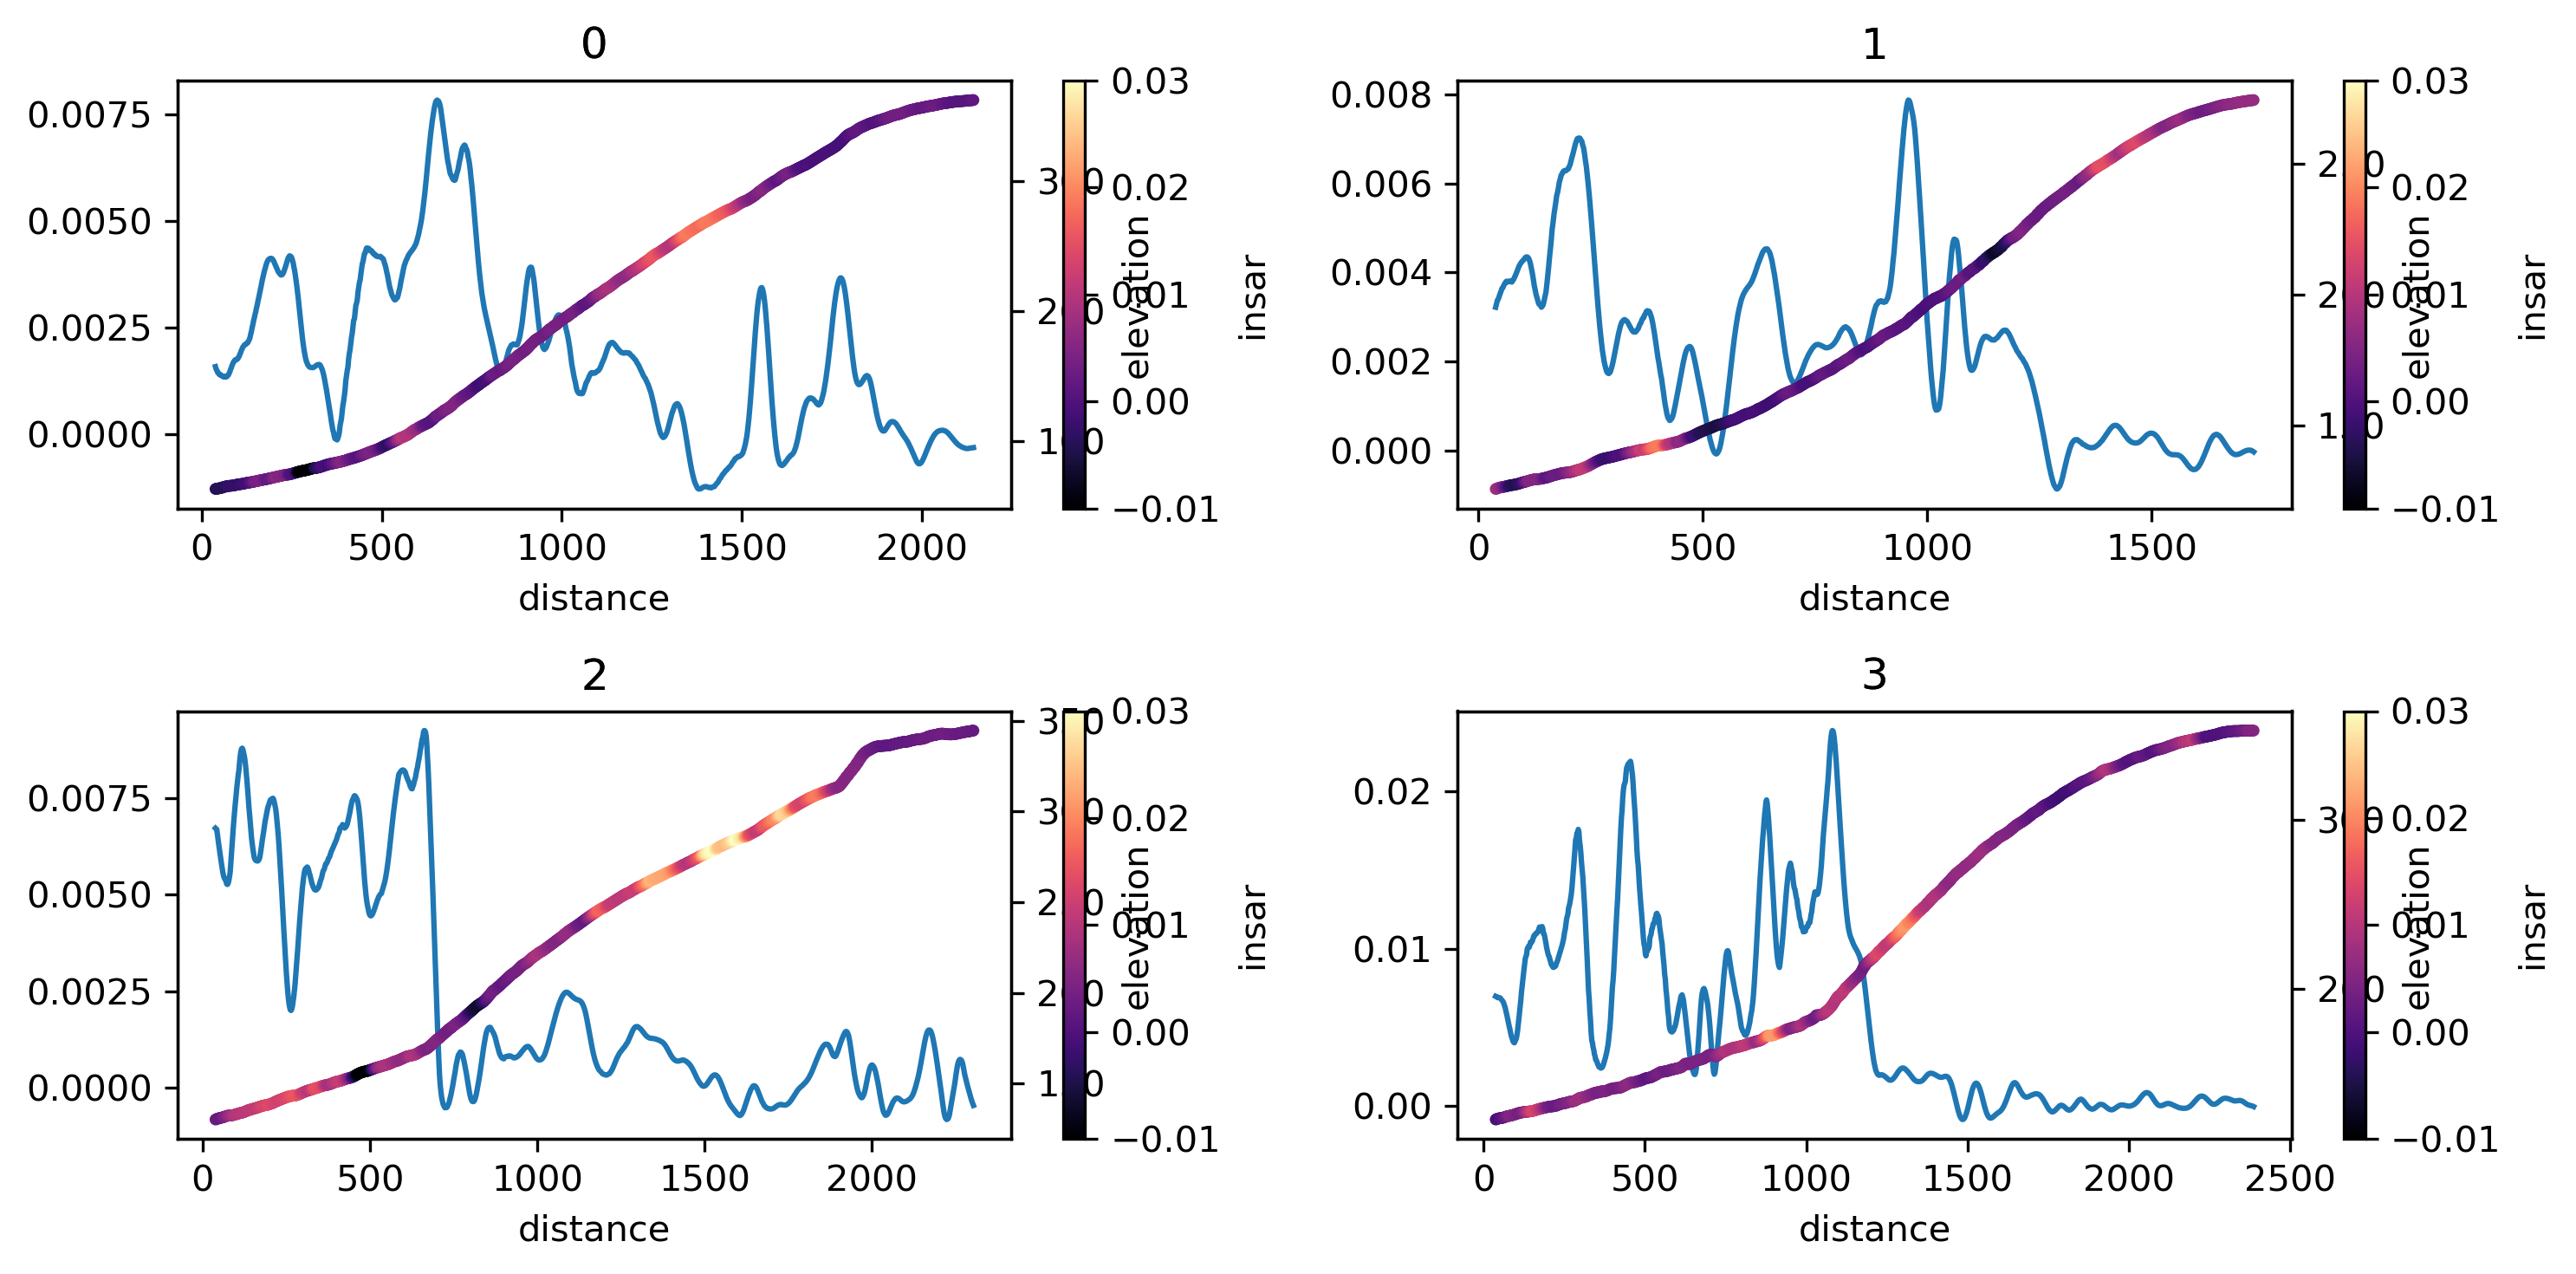

In [118]:
fig, axes = plt.subplots(2,2, figsize=(10,5), dpi=300)
for (profile, group), ax in zip(multiprofile_df.groupby('profile'), axes.flatten()):
    group.plot(x='distance', y='curv', kind='line', legend=False,
            # c='insar', cmap='magma', vmax=0.03, vmin=-0.01,
            ax=ax, title=str(profile))
    ax2 = ax.twinx()
    group.plot(x='distance', y='elevation', kind='scatter', s=5,
               c='insar', cmap='magma', vmax=0.03, vmin=-0.01,
               ax=ax2, title=str(profile))



fig.tight_layout()

#plt.savefig(('./figure_outputs/hillslope_transects.png'), bbox_inches="tight")


# https://stackoverflow.com/questions/33150510/how-to-create-groupby-subplots-in-pandas

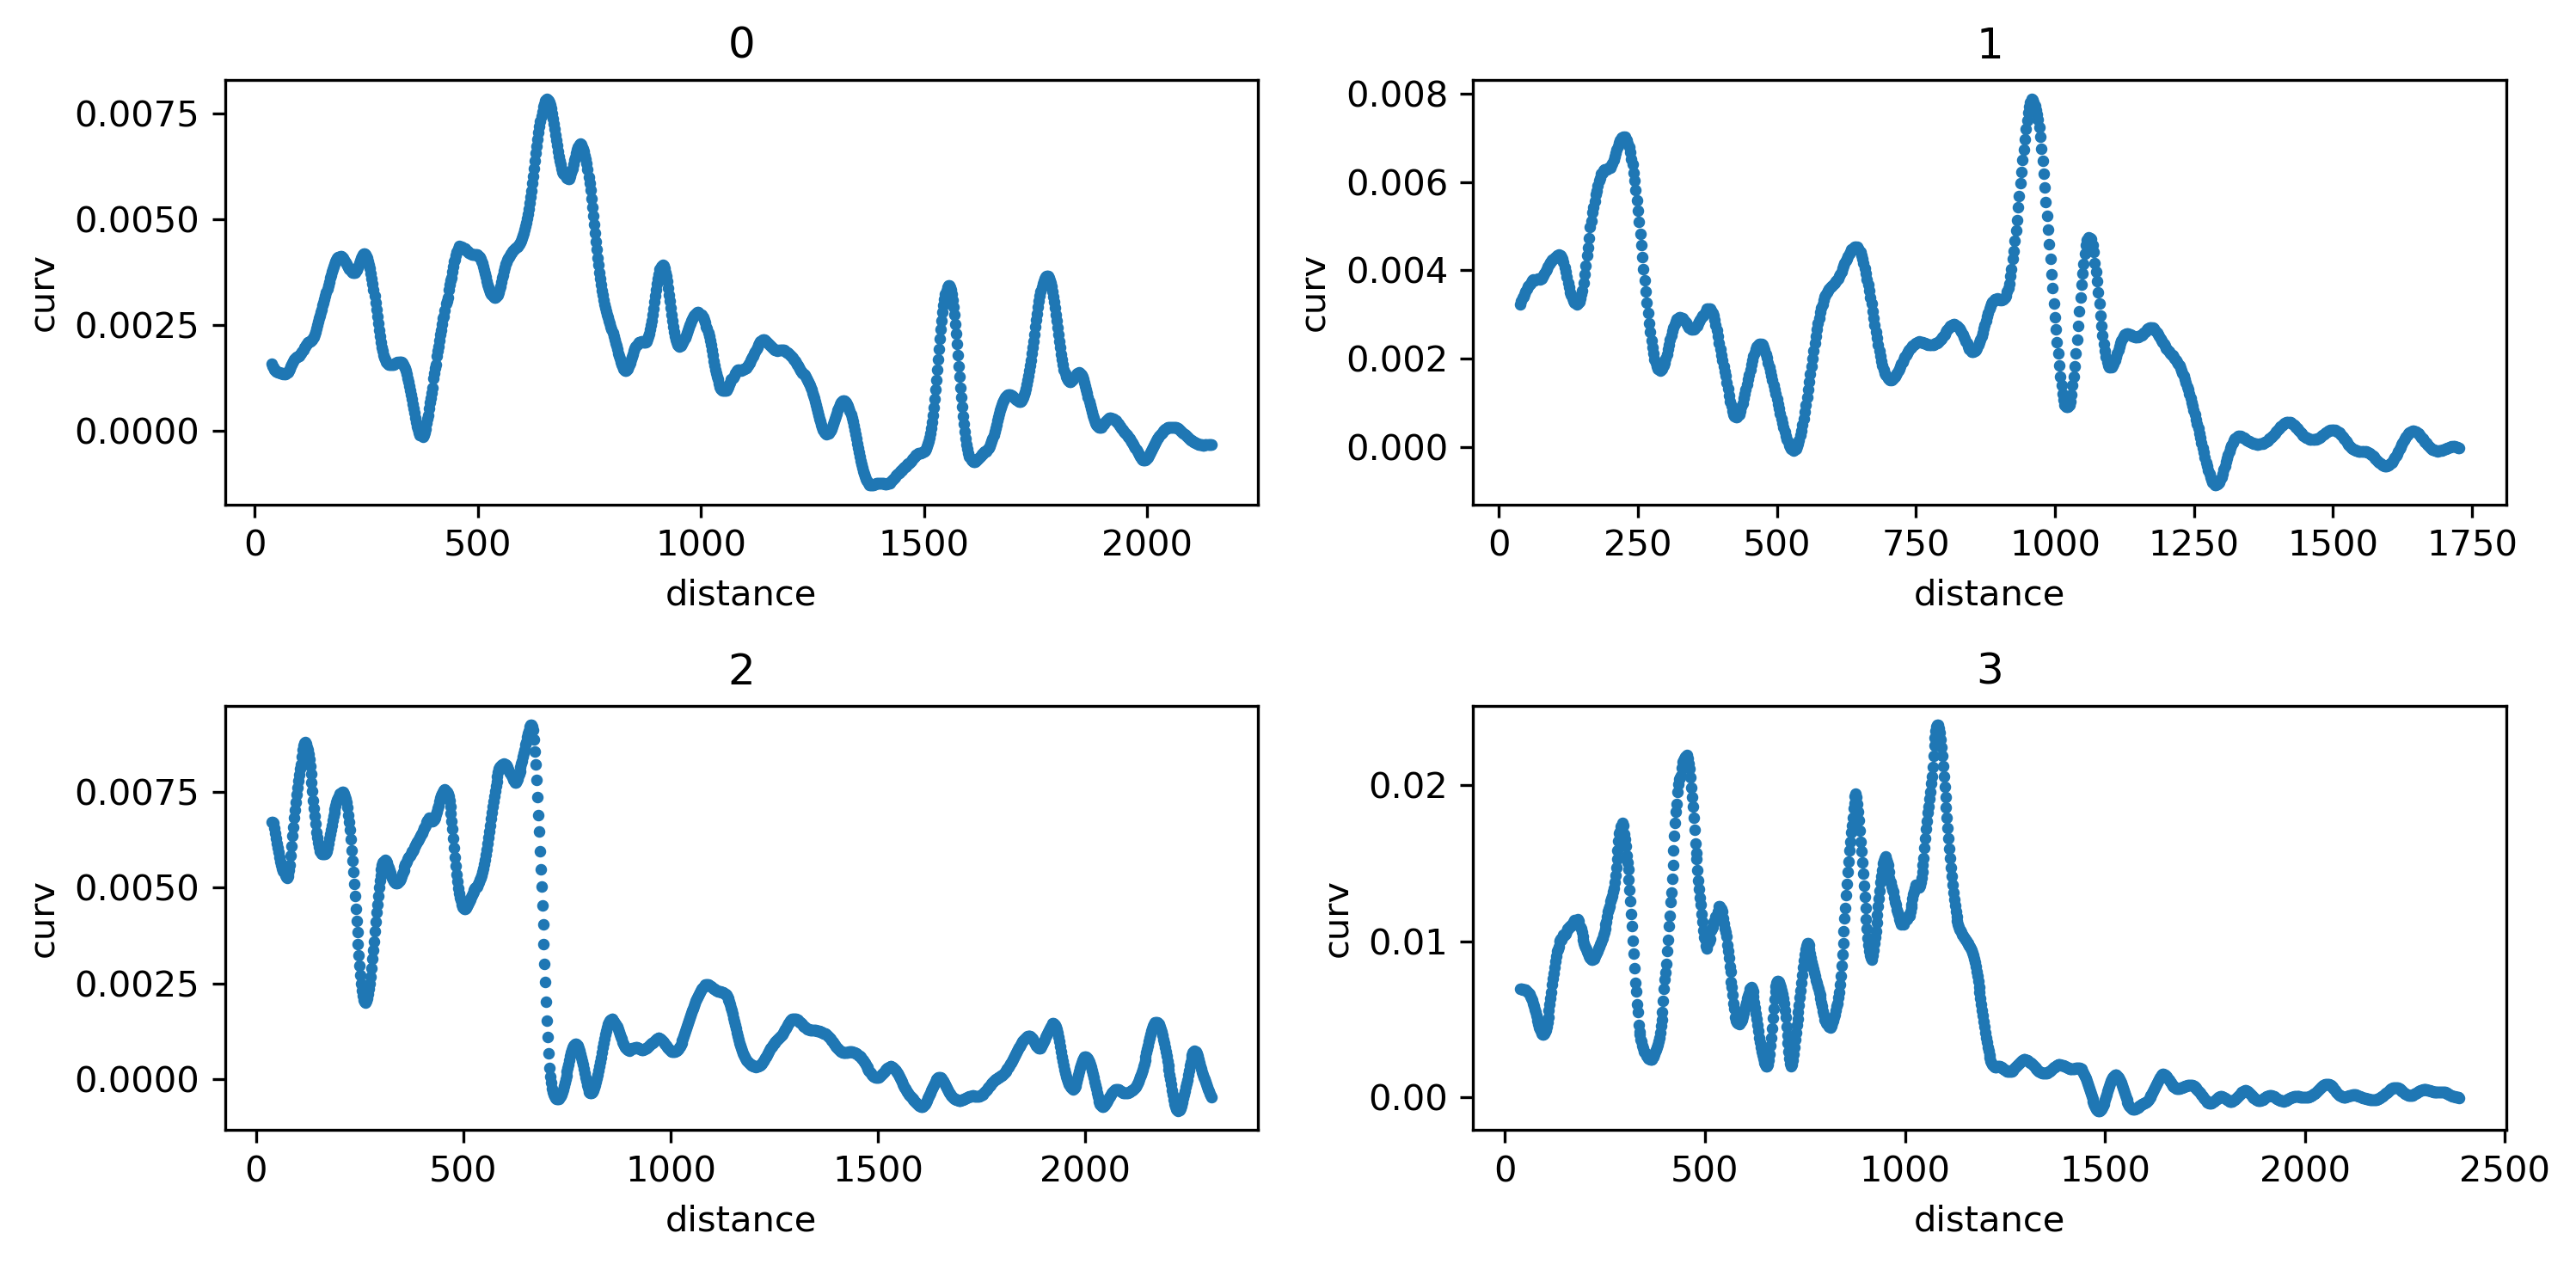

In [111]:
fig, axes = plt.subplots(2,2, figsize=(10,5), dpi=300)
# for (profile, group), ax in zip(multiprofile_df.groupby('profile').groups.items(), axes.flatten()):
grouped = multiprofile_df.groupby('profile')
for profile, ax in zip(multiprofile_df.profile.unique(), axes.flatten()):
   multiprofile_df.loc[multiprofile_df.profile==profile].plot(x='distance', y='curv', kind='scatter', s=5,
               # c='curv', cmap='magma',
            #    vmax=0.02, vmin=-0.01,
               ax=ax, title=str(profile))
fig.tight_layout()

#plt.savefig(('./figure_outputs/hillslope_transects.png'), bbox_inches="tight")


# https://stackoverflow.com/questions/33150510/how-to-create-groupby-subplots-in-pandas

# Computationally intensive steps to run only once

## Sample raster stack at basin points (run once)

In [10]:
# I use the "split-apply-combine" workflow to split up the landscape into basins and then perform analyses based on basin averages,
# ranges, etc. hence why I am calling the basin raster the "splitter"

In [ ]:
import glob

stack = [(os.path.basename(name)) for name in glob.glob((os.path.join(basic_stack_dir,'*.tif')))]

stack_names = [os.path.splitext(name)[0] for name in stack]

print(stack_names)

# Build a "stack" of rasters and get the name of the raster file to describe the dataset for column names in the 
# resulting dataframe. 

In [ ]:
splitter_raster = './lsdtt_exports/hcc_AllBasins.tif'
splitter_raster_var = "junct"

# LSDTopoTools exports a raster file in which delineated basins are given data values that correspond to the
# specific junction that defines their outlet, which are just some of the many junctions the algorithm
# generates, resulting in raster values like 217, 336, 387, etc. A file called "AllBasinsInfo.csv" lists the junction number
# and the basin ID number which follows more logically 1, 2, 3 etc. 

In [ ]:
### Step 1: Get "splitter" raster as a set of coordinates
# Think about writing this to save memory
rds = rxr.open_rasterio(
    splitter_raster,
)
rds = rds.squeeze().drop("spatial_ref").drop("band")
rds.name = splitter_raster_var #the basin raster is written with the outlet_junction from the AllBasins.csv
df = rds.to_dataframe().reset_index()

#Eliminate data points where the basin raster did not have a basin
df=df[df[splitter_raster_var]>=0.0] 

#Convert them to integers 
df.junct = df[splitter_raster_var].astype(int)

coords = [(x,y) for x, y in zip(df.x, df.y)]

### Step 2: Sample the stack across the splitter raster while retaining the raster's splitter variable 
# sample data from rasters
for i, raster_file in enumerate(stack):
    # Sample the raster at every point location and store values in DataFrame
    src = rasterio.open((os.path.join(basic_stack_dir, raster_file)))
    col = stack_names[i]
    print(col)
    df[col] = [x[0] for x in src.sample(coords)]
    src.close()

### Save so we don't have to do that again

In [ ]:
df.to_csv('./splitter_raster_stack_sample_raw.csv')

## Clean some nodatas 

In [ ]:
# Clean where NoData values are

curv_column = 'seward_hsp__tan_curv_LW'
slope_column = 'slope_15m'
    
df.loc[df[slope_column]< -100.0 ] = np.nan

# The default for some of these seems to be -3
df.loc[df[curv_column]<= -3.0 ] = np.nan
df.loc[df['insar_displacement']<= -3.0 ] = np.nan

##  Add an outlet elevation by assuming minimum elevation in each basin is the outlet

In [ ]:
df['Outlet Elev'] = df.junct.map(df.groupby(['junct']).min()['seward2_hsp_elev'])

## Save cleaned and augmented data

In [ ]:
df.to_csv('./splitter_raster_stack_sample.csv')

## Normalize for LOS bias with pixelwise z-scores for aspect groups

Since InSAR displacements are dependent on line-of-sight (LOI), I'm going to calculate z-scores for displacement of pixels in 8 direction bins, which would be like cardinal directions but will center on the LOS of the satellite to be more precise then cardinal directions

## Use GDAL to resample ArcticDEM to resolution of InSAR raster with pixels aligned

*Coming soon!* Right now the rasters are for our purposes "good enough" (the pixels aren't aligned but sampling the center of one pixel correctly captures the overlapping data) but someday (e.g. differencing arcticdem and lidar scans, which was a headache in GDAL but easy in Arc.....) I need to write this script. StackExchange is not helpful somehow

## Bin all pixels into 8 direction bins based on LOS

look direction of satellite: from west (-103 degrees from N or 257)

In [ ]:
# These angles are adjusted slightly to make "west" at 257 to more precisely align with LOS

df['asp_card'] = pd.cut(df['aspect_15m'],
                        [0, 9.5, 54.5, 99.5, 144.5, 189.5, 234.5, 279.5, 324.5, 360],
                        labels=["N", "NE", "E", "SE","S", "SW", "W", "NW", "N"],
                        ordered=False
                       )

## Calculate pixelwise displacement z-score for each bin

In [ ]:
cardinal_order = ["N", "NE", "E", "SE","S", "SW", "W", "NW"]

df['disp_zscore'] = np.nan

# Edge effects of model made anomalously high displacements on edges of scene. No "real" values are more than 0.07 m

df.loc[df['insar_displacement']>0.07]['insar_displacement'] = np.nan

for cardinal in df['asp_card'].unique():
    numerator = df.loc[df['asp_card'] == cardinal]['insar_displacement'] - df.loc[df['asp_card'] == cardinal]['insar_displacement'].mean()
    denomenator = df.loc[df['asp_card'] == cardinal]['insar_displacement'].std(ddof=0)
    zscores = numerator/denomenator
    df['disp_zscore'].loc[df['asp_card'] == cardinal] = zscores

## Polygonize basin raster for plotting (run once)

In [4]:
df = pd.read_csv('./splitter_raster_stack_sample.csv')

In [ ]:
from rasterio.features import shapes
mask = None
with rasterio.Env():
    with rasterio.open(splitter_raster) as src:
        image = src.read(1) # first band
        results = (
        {'properties': {splitter_raster_var: v}, 'geometry': s}
        for i, (s, v) 
        in enumerate(
            shapes(image, mask=mask, transform=src.transform)
        ))

        geoms = list(results)

        gpd_polygonized_raster  = gpd.GeoDataFrame.from_features(geoms, crs=src.crs) #Joanmarie added that last bit for crs

#https://gis.stackexchange.com/questions/187877/how-to-polygonize-raster-to-shapely-polygons/187883

gpd_polygonized_raster_orig = gpd_polygonized_raster[gpd_polygonized_raster[splitter_raster_var] >= 0.0]





In [ ]:
#df[splitter_raster_var] = df[splitter_raster_var].astype(int)
# This is another instance when I was cleaning that somehow junctions became Nans....
df_mean = df.groupby('junct').mean().reset_index()

# Add attributes to shapefile
gpd_polygonized_raster = gpd_polygonized_raster_orig.merge(df_mean, on='junct')

#Add basin area column 
gpd_polygonized_raster['Area'] = gpd_polygonized_raster['geometry'].area

#Eliminate basins that are too small - not sure how these got in here...
gpd_polygonized_raster.loc[gpd_polygonized_raster.Area < 100.0, 'Area'] = np.nan
gpd_polygonized_raster['area_km2'] = gpd_polygonized_raster['Area']/1000000

gpd_polygonized_raster=gpd_polygonized_raster.dropna()

In [ ]:
gpd_polygonized_raster.to_file('basins_with_attributes.shp')

# Load polygonized raster and stack data to plot and analyze

In [11]:
gpd_polygonized_raster = gpd.read_file('basins_with_attributes.shp')
gpd_polygonized_raster['area_km2'] = gpd_polygonized_raster['Area']/1000000

In [12]:
slopeshade = rasterio.open((os.path.join(basic_stack_dir,'slope_15m.tif')), masked=True)

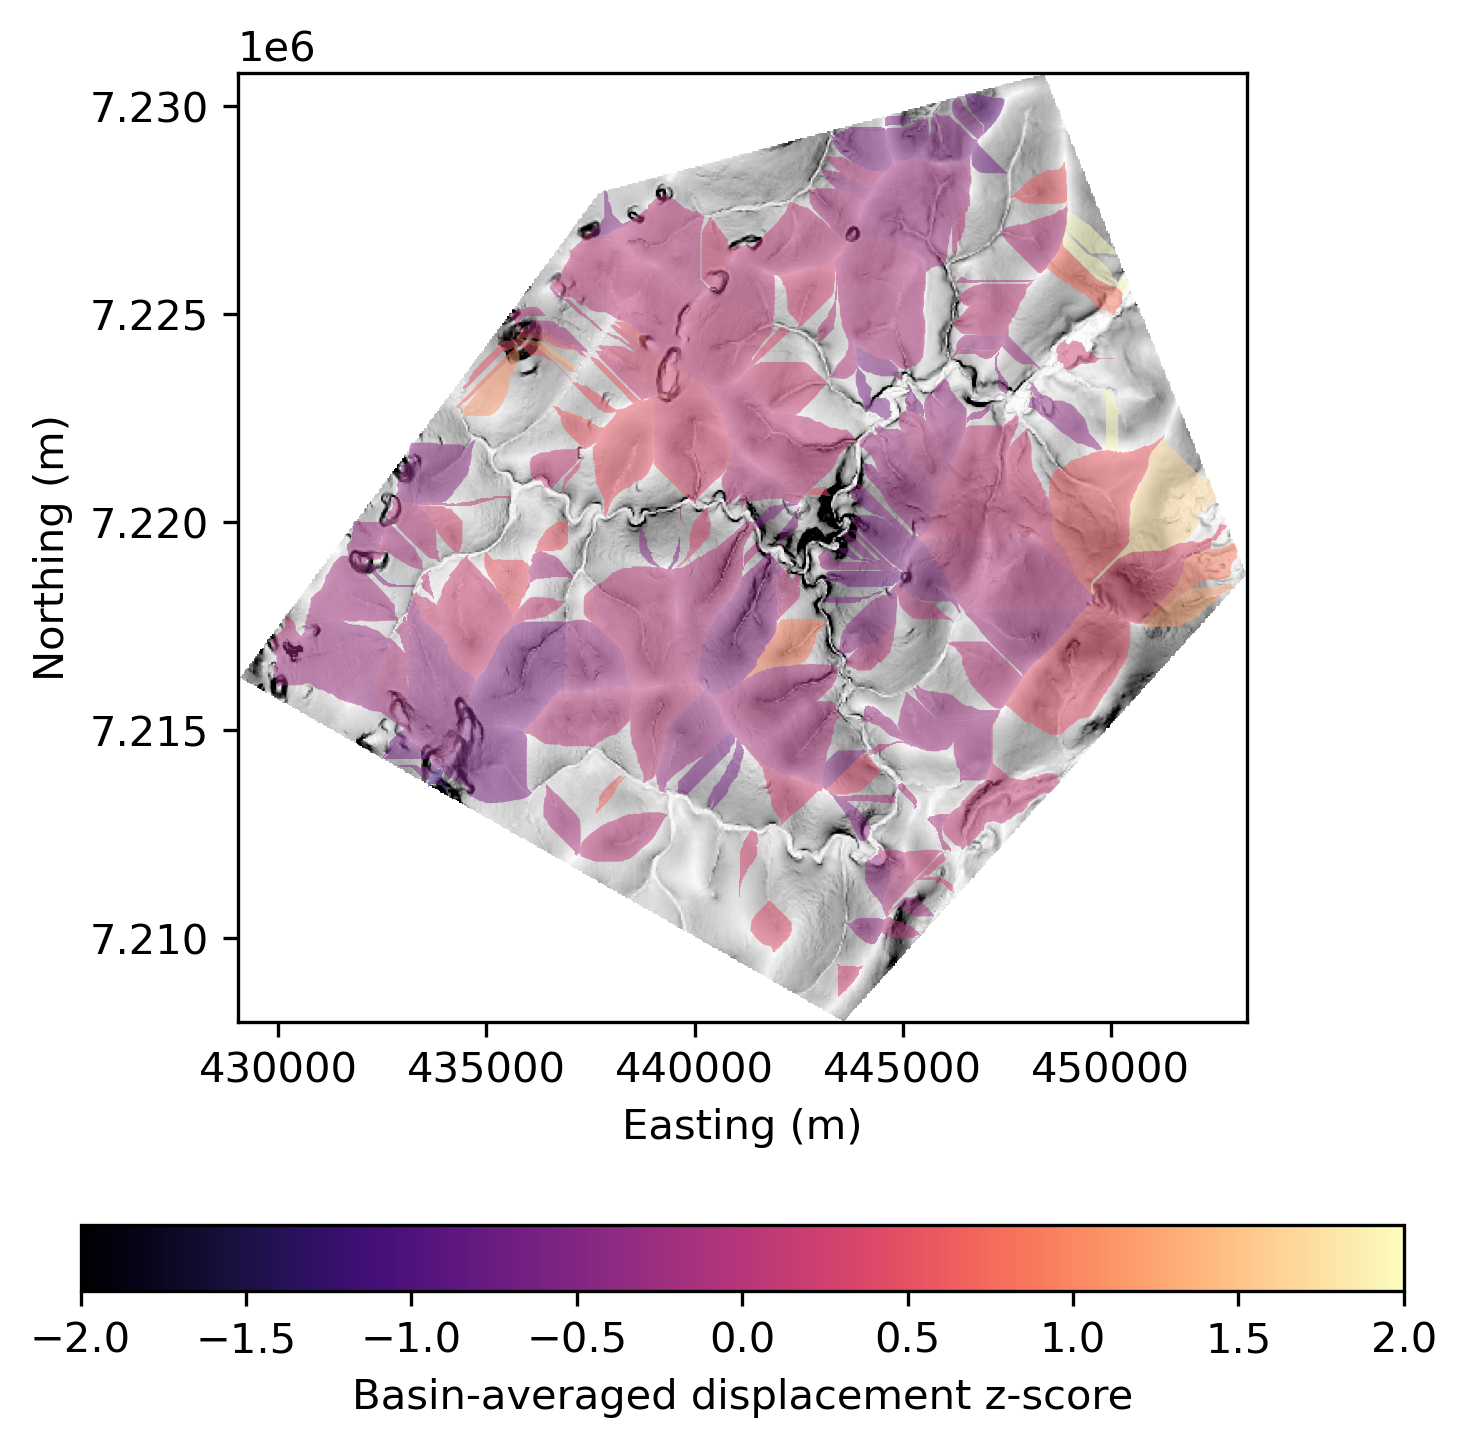

In [13]:
fig, ax = plt.subplots(figsize=(5,5),dpi=300)
slope = rasterio.plot.show(slopeshade, vmin=0.0, vmax=0.4, cmap='binary',  ax=ax, zorder=0)   
basins = gpd_polygonized_raster.plot(column='disp_zscor',cmap='magma',
                                     vmax=2,
                                     vmin=-2,
                                     alpha=0.5,
                                     ax=ax,
                                     zorder=1,
                                     legend=True, 
                                     legend_kwds={'label': "Basin-averaged displacement z-score",
                        'orientation': "horizontal"})
ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')

fig.tight_layout()

# plt.savefig('./figure_outputs/basin_zscores.png')

(0.0, 0.3)

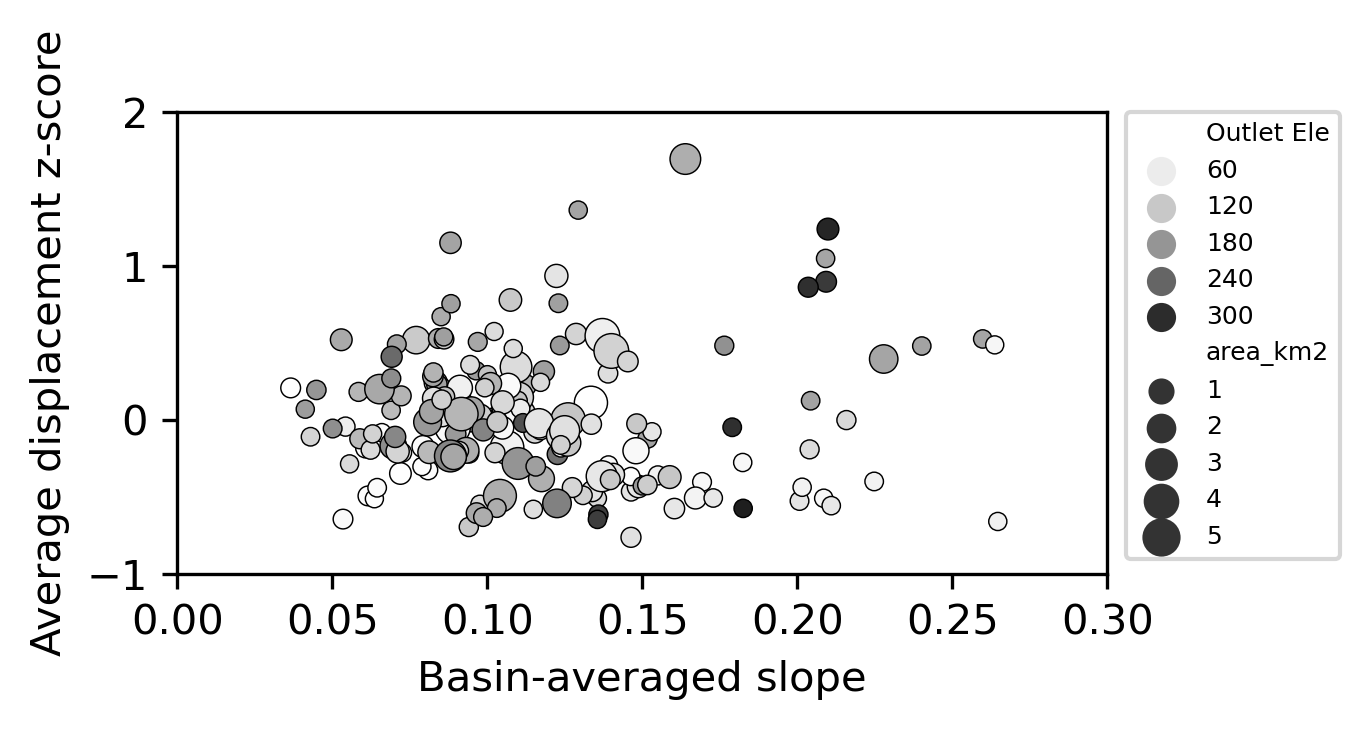

In [18]:
fig, ax = plt.subplots(figsize=(4,2),dpi=300)
palette = sns.color_palette("Greys", as_cmap=True)

scatter1 = sns.scatterplot(x='slope_15m', y='disp_zscor',
                           hue='Outlet Ele',
                           size='area_km2',
                           data=gpd_polygonized_raster,
                           edgecolor='black',
                           #hue_norm=(-1,2),
#                            vmin=-2.0,
#                            vmax=2.0,
                           legend='brief', #'full'
                           palette=palette,
                           ax=ax)

plt.legend(title=None, fontsize='6', title_fontsize='14', 
           bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
ax.set_ylabel('Average displacement z-score')

ax.set_xlabel('Basin-averaged slope')
ax.set_ylim(-1,2)
ax.set_xlim(0,0.3)

# plt.savefig('./figure_outputs/slope_zscore_scatter.png', bbox_inches="tight")

(0.0, 0.3)

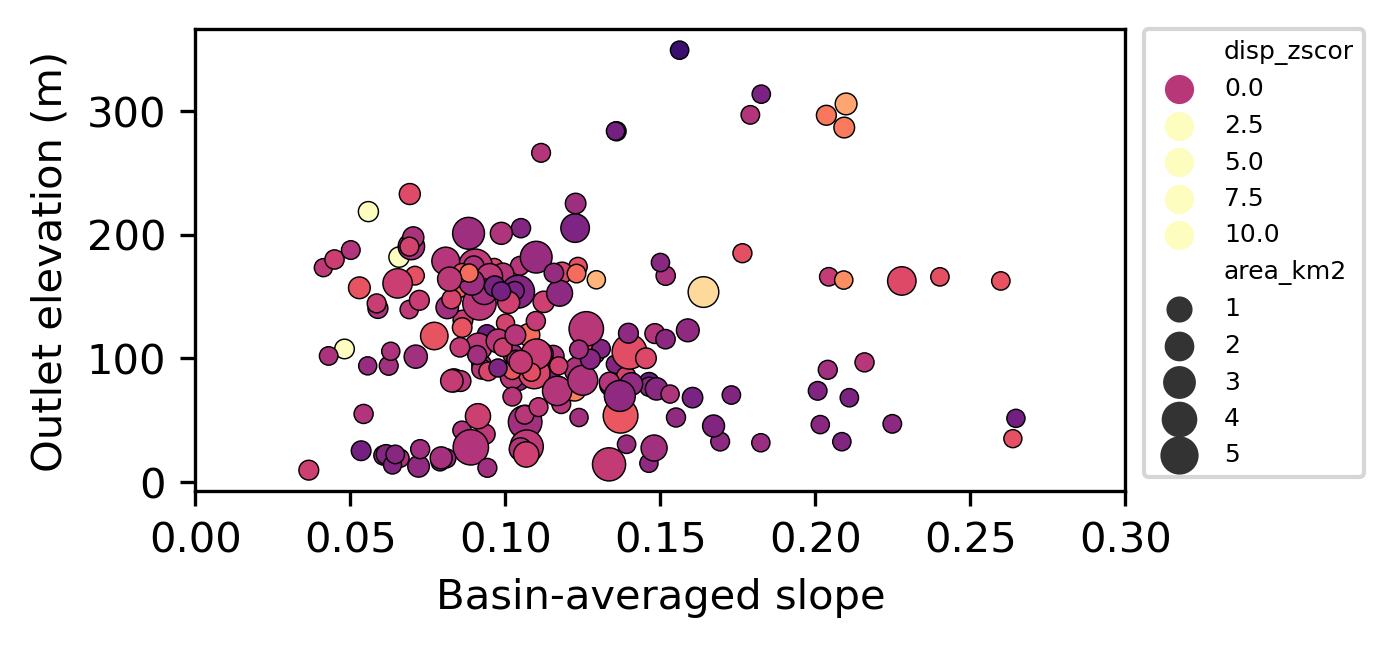

In [14]:
fig, ax = plt.subplots(figsize=(4,2),dpi=300)
palette = sns.color_palette("magma", as_cmap=True)

scatter1 = sns.scatterplot(x='slope_15m', y='Outlet Ele',
                           hue='disp_zscor',
                           size='area_km2',
                           data=gpd_polygonized_raster,
                           edgecolor='black',
                           hue_norm=(-2,2),
                           # vmin=-2.0,
                           # vmax=2.0,
                           legend='brief', #'full'
                           palette=palette,
                           ax=ax)

plt.legend(title=None, fontsize='6', title_fontsize='14', 
           bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
ax.set_ylabel('Outlet elevation (m)')

ax.set_xlabel('Basin-averaged slope')
# ax.set_ylim(-1,3)
ax.set_xlim(0,0.3)

# plt.savefig('./figure_outputs/slope_outlet_scatter.png', bbox_inches="tight")

# Channel steepness figures

In [15]:
lsdtt_dir = './lsdtt_exports/'

In [16]:
basins = gpd.read_file('basins_with_attributes.shp')

## Create geodataframe of river profile points from LSDTT chi analysis export

In [17]:
from shapely.geometry import Point

river_profiles = pd.read_csv(os.path.join(lsdtt_dir,"chi4_MChiSegmented.csv"))
geometry = [Point(xy) for xy in zip(river_profiles['longitude'], river_profiles['latitude'])]
river_profiles = gpd.GeoDataFrame(river_profiles, crs='epsg:4326', geometry=geometry)
#I was working in 3N

river_profiles = river_profiles.to_crs(basins.crs)

# Back-calculate channel slope....I think. Lol. 

river_profiles['channel_slope'] = river_profiles['m_chi'] * (river_profiles['drainage_area']**(-0.5))

## Connect river profiles to basin geodataframe

In [18]:
chi_basins = gpd.sjoin(river_profiles, basins, how = 'left')

chi_basins['junct'] = chi_basins['junct'].fillna(9999)

basin_averaged_chi = chi_basins.groupby(by='junct').mean().reset_index()

# This is the big one through the middle
main_drainage = chi_basins.loc[chi_basins['basin_key']==20]

## Plot steep river reaches in map view

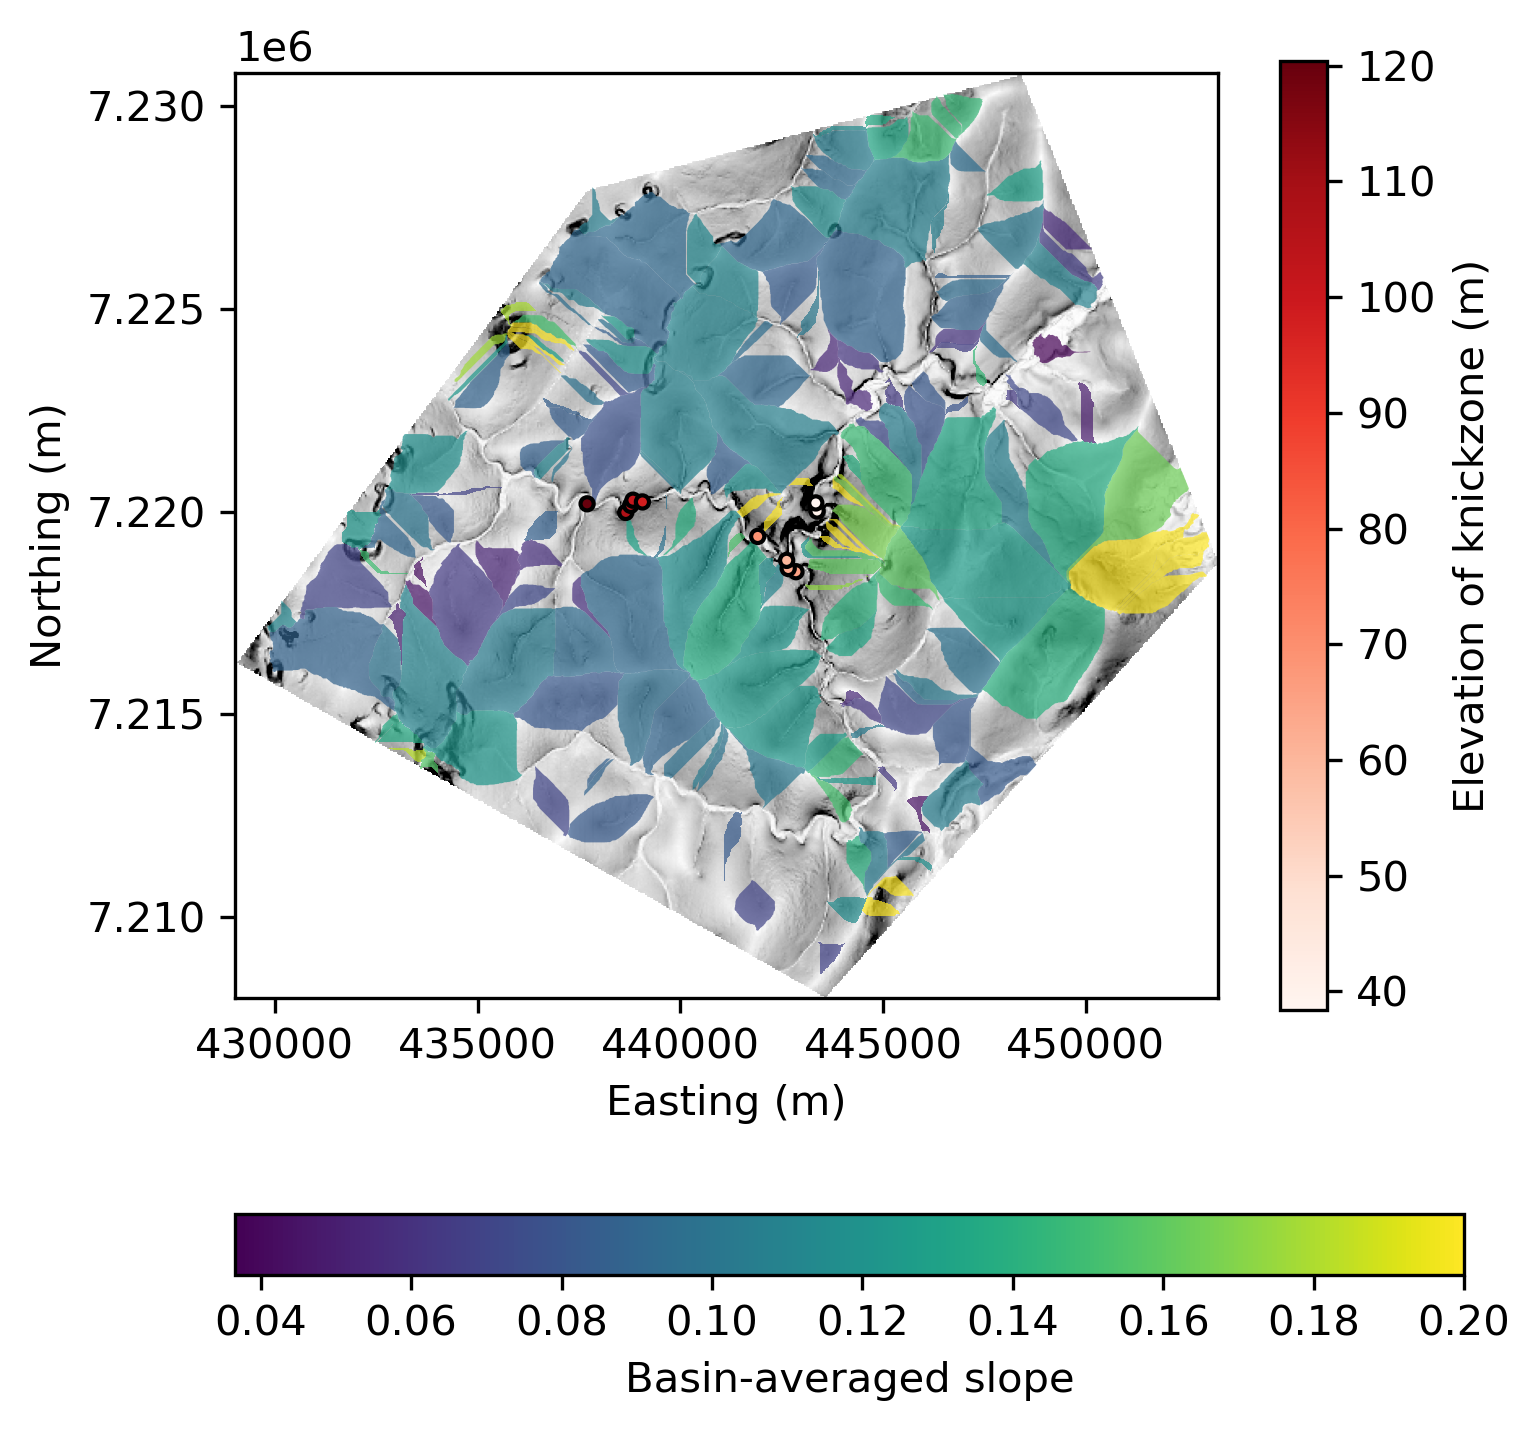

In [20]:
from rasterio.plot import show

slopeshade = rasterio.open((os.path.join(basic_stack_dir,'slope_15m.tif')), masked=True)

fig, ax = plt.subplots(figsize=(5,5), dpi=300)
slope = rasterio.plot.show(slopeshade, vmin=0.0, vmax=0.4, cmap='binary', ax=ax, zorder=0)                            
basins = gpd_polygonized_raster.plot(column='slope_15m', cmap='viridis', vmax=0.2, ax=ax, alpha=0.7, zorder=1, legend=True,
                                    legend_kwds={'label': "Basin-averaged slope",
                        'orientation': "horizontal"})
# network = main_drainage.loc[main_drainage['drainage_area']>4e7][::50].plot(column='channel_slope',
#                               cmap='gnuplot',
#                               norm=colors.LogNorm(),
#                               #vmax = 1E-3,
#                               edgecolor='none', markersize=2, ax=ax,zorder=2,
#                                             legend=True,
#                                             legend_kwds={'label': "Channel slope (m/m)",
#                                                          'orientation': "vertical"})
network2 = main_drainage[(main_drainage['drainage_area'] > 4E7)  & (main_drainage['channel_slope'] > 1e-2)][::100].plot(column='elevation',
                                                                                                                 cmap='Reds',
                                                                                                                 markersize=10,
                                                                                                                 edgecolor='k',
                                                                                                                 ax=ax,
                                                                                                                 zorder=3,
                                                                                                                 legend=True,
                                                                                                                    legend_kwds={'label': "Elevation of knickzone (m)",
                                                                                                                                 'orientation': "vertical"})

ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')

fig.tight_layout()

# plt.savefig('./figure_outputs/basin_slope_kz.png', bbox_inches="tight")

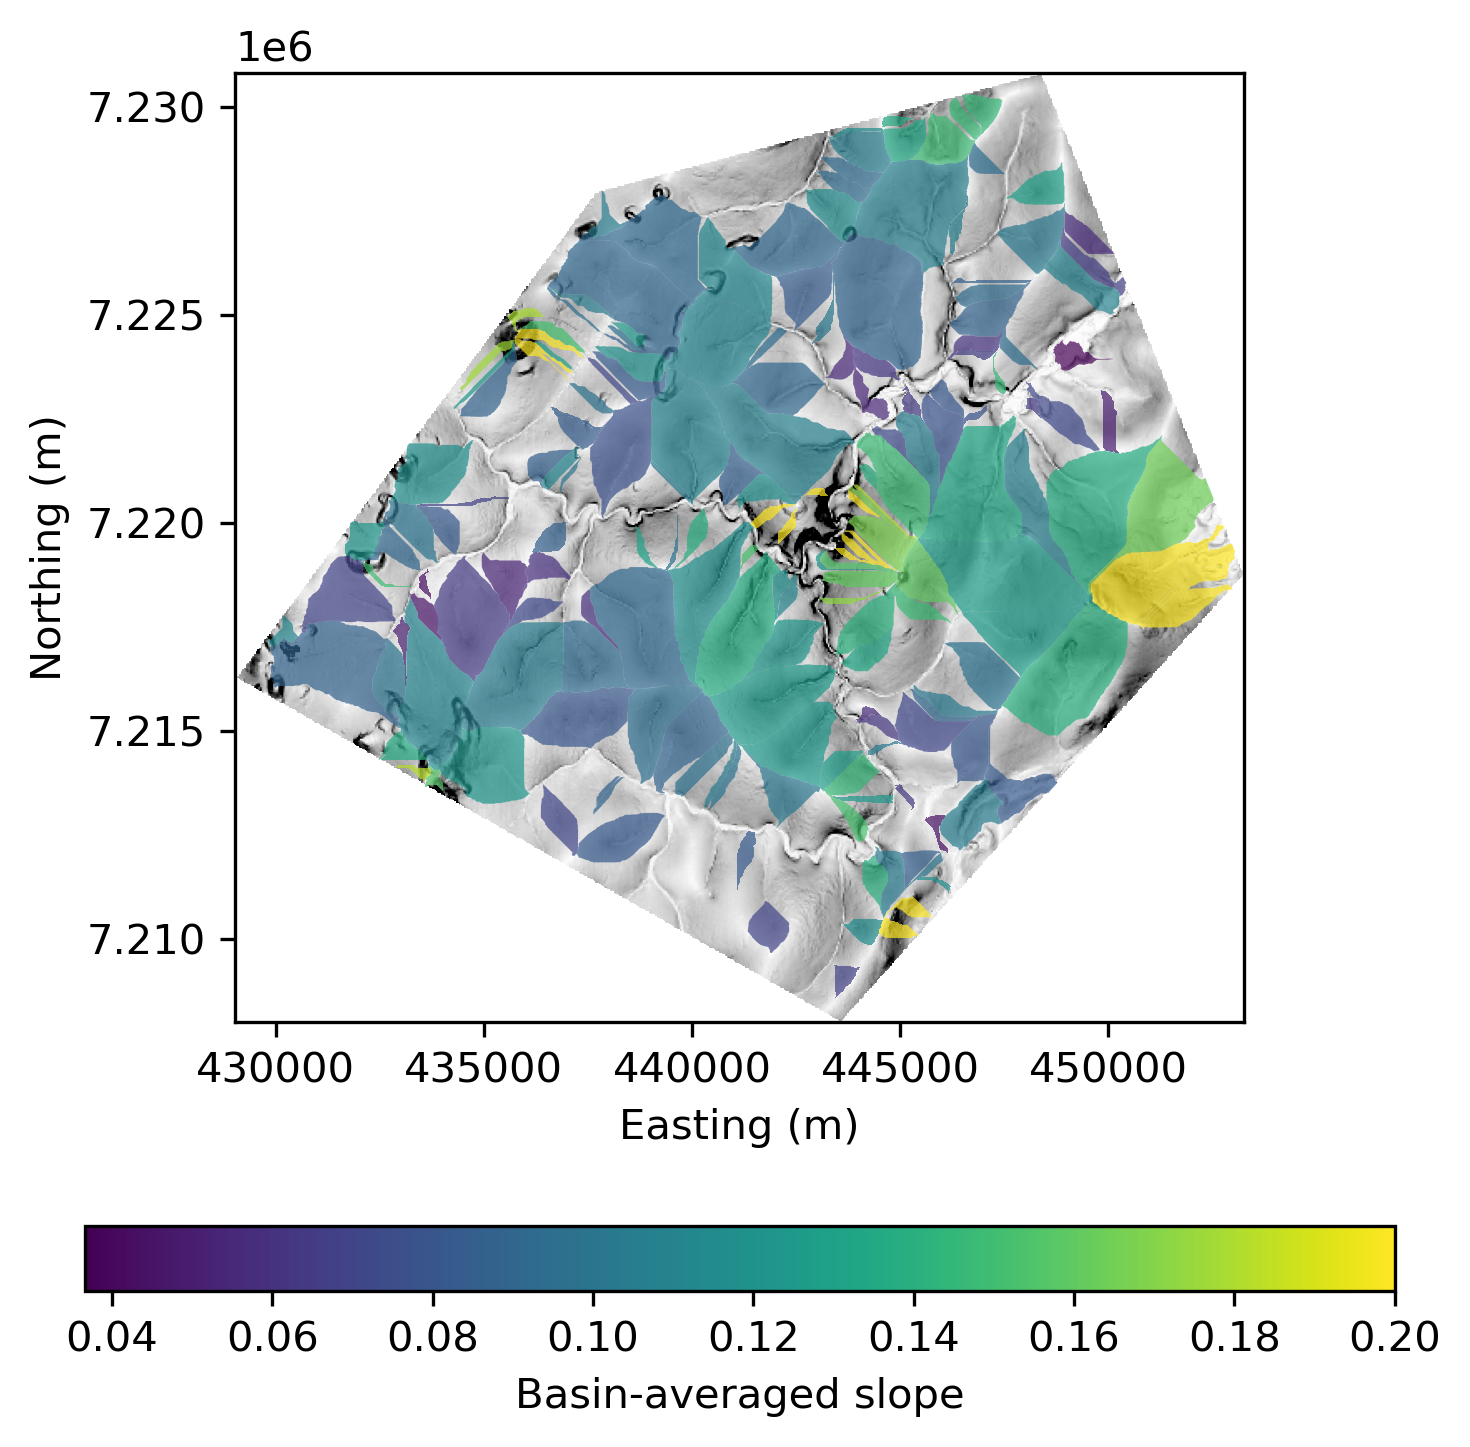

In [21]:
from rasterio.plot import show

slopeshade = rasterio.open((os.path.join(basic_stack_dir,'slope_15m.tif')), masked=True)

fig, ax = plt.subplots(figsize=(5,5), dpi=300)
slope = rasterio.plot.show(slopeshade, vmin=0.0, vmax=0.4, cmap='binary', ax=ax, zorder=0)                            
basins = gpd_polygonized_raster.plot(column='slope_15m', cmap='viridis', vmax=0.2, ax=ax, alpha=0.7, zorder=1, legend=True,
                                    legend_kwds={'label': "Basin-averaged slope",
                        'orientation': "horizontal"})
# network = main_drainage.loc[main_drainage['drainage_area']>4e7][::50].plot(column='channel_slope',
#                               cmap='gnuplot',
#                               norm=colors.LogNorm(),
#                               #vmax = 1E-3,
#                               edgecolor='none', markersize=2, ax=ax,zorder=2,
#                                             legend=True,
#                                             legend_kwds={'label': "Channel slope (m/m)",
#                                                          'orientation': "vertical"})
# network2 = main_drainage[(main_drainage['drainage_area'] > 4E7)  & (main_drainage['channel_slope'] > 1e-2)][::100].plot(column='elevation',
#                                                                                                                  cmap='Reds',
#                                                                                                                  markersize=10,
#                                                                                                                  edgecolor='k',
#                                                                                                                  ax=ax,
#                                                                                                                  zorder=3,
#                                                                                                                  legend=True,
#                                                                                                                     legend_kwds={'label': "Elevation of knickzone (m)",
#                                                                                                                                  'orientation': "vertical"})

ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')

fig.tight_layout()

# plt.savefig('./figure_outputs/basin_slope_no_kz.png', bbox_inches="tight")

Text(0.5, 0, 'Flow distance (m)')

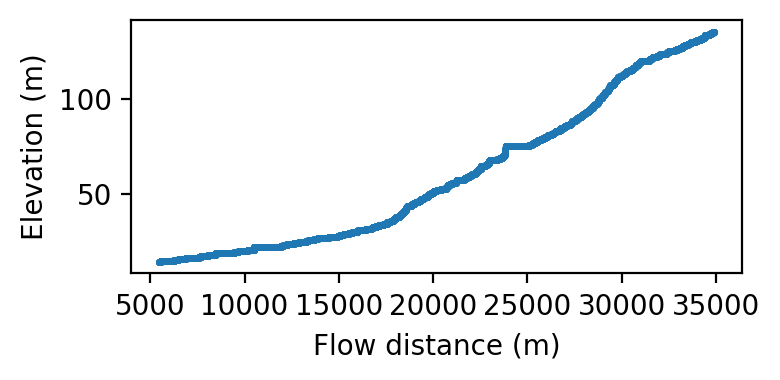

In [22]:
fig, ax = plt.subplots(figsize=(4,2), dpi=200, tight_layout=True)

pal0 = palette = sns.color_palette("viridis", as_cmap=True)

main_drainage = chi_basins.loc[chi_basins['basin_key']==20]
rivers = sns.scatterplot(x=main_drainage.loc[main_drainage['drainage_area']>4.5e7]['flow_distance'],
               y=main_drainage.loc[main_drainage['drainage_area']>4.5e7]['elevation'], 
               #hue=main_drainage.loc[main_drainage['drainage_area']>4.5e7]['m_chi'],
                         edgecolor=None,
                         #palette=pal0,
                         s=5,
                         ax=ax,
                    
               )
ax.set_ylabel("Elevation (m)")
ax.set_xlabel("Flow distance (m)")
# plt.savefig('./figure_outputs/long_profile_main.png', bbox_inches="tight")

## Grab a few longitudinal profiles that demonstrate knickzone elevation

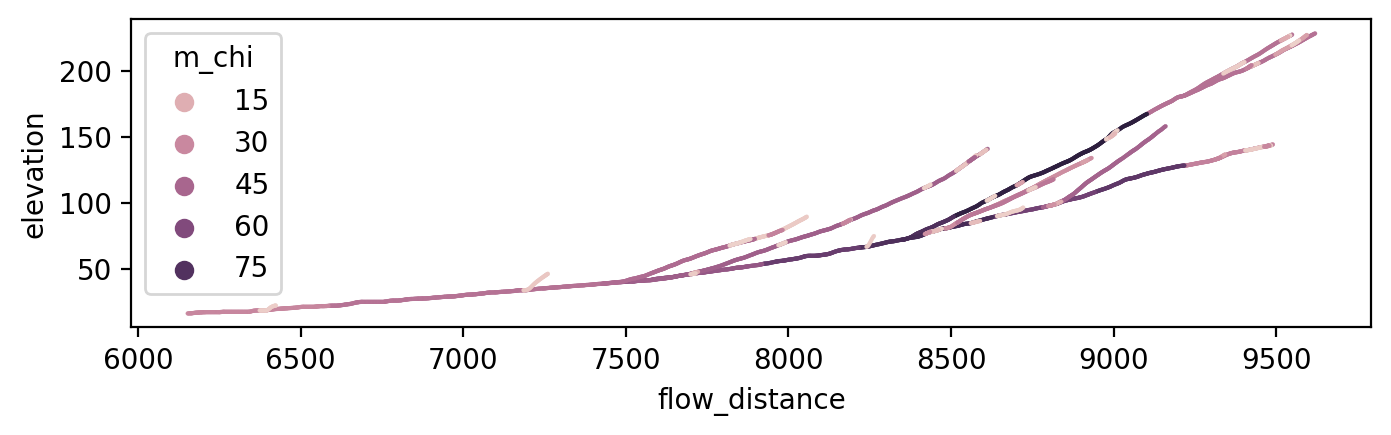

In [23]:
fig, ax = plt.subplots(figsize=(8,2), dpi=200)
rivers = sns.scatterplot(x=chi_basins.loc[chi_basins['junct']==1327.0]['flow_distance'],
               y=chi_basins.loc[chi_basins['junct']==1327.0]['elevation'], 
               hue=chi_basins.loc[chi_basins['junct']==1327.0]['m_chi'],
                         edgecolor=None,
                         s=2,
                         ax=ax,
                    
               )

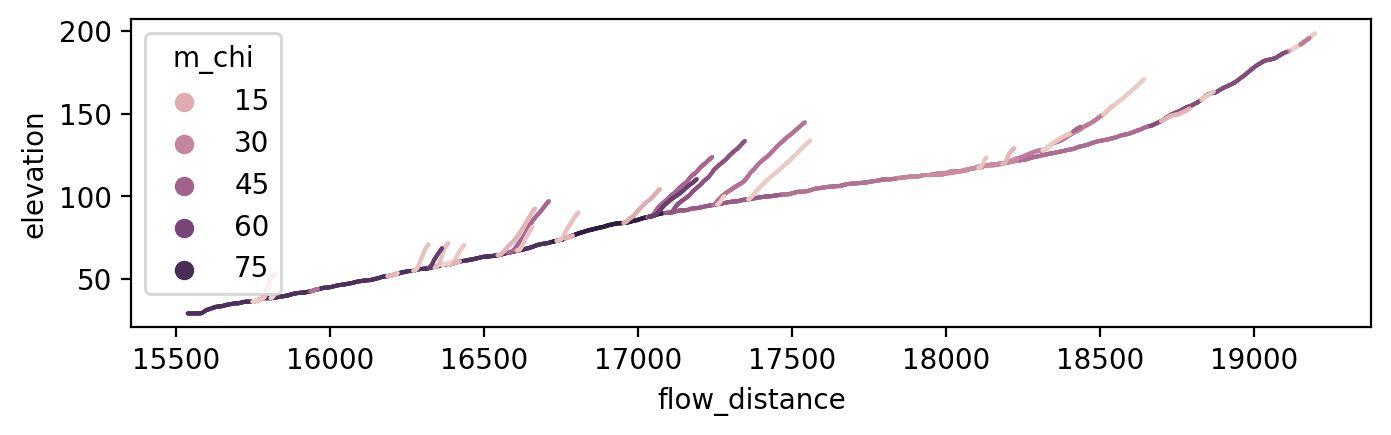

In [24]:
fig, ax = plt.subplots(figsize=(8,2), dpi=200)
rivers = sns.scatterplot(x=chi_basins.loc[chi_basins['junct']==1200.0]['flow_distance'],
               y=chi_basins.loc[chi_basins['junct']==1200.0]['elevation'], 
               hue=chi_basins.loc[chi_basins['junct']==1200.0]['m_chi'],
                         edgecolor=None,
                         s=2,
                         ax=ax,
                    
               )

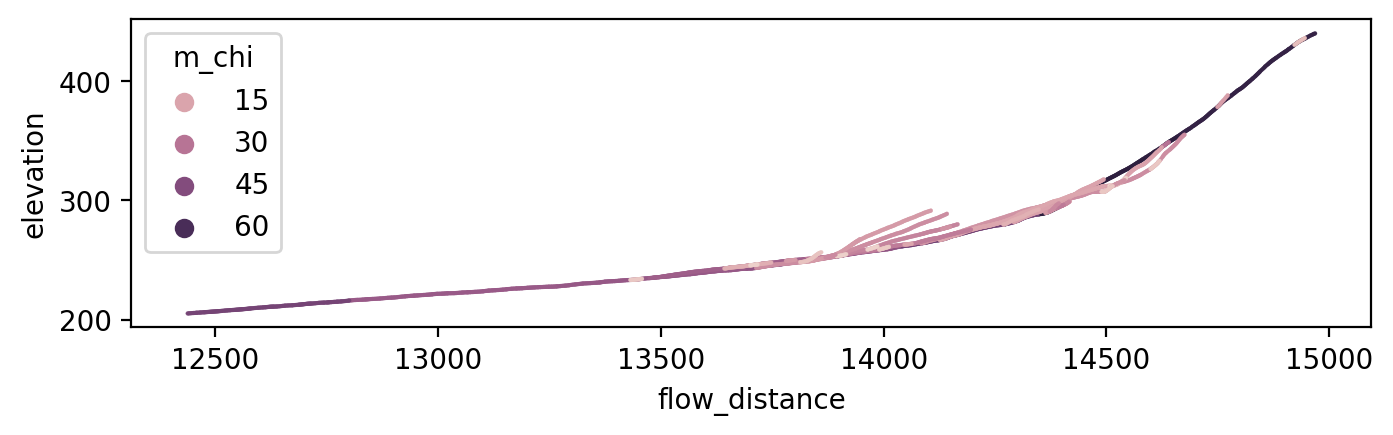

In [25]:
fig, ax = plt.subplots(figsize=(8,2), dpi=200)
rivers = sns.scatterplot(x=chi_basins.loc[chi_basins['junct']==3567.0]['flow_distance'],
               y=chi_basins.loc[chi_basins['junct']==3567.0]['elevation'], 
               hue=chi_basins.loc[chi_basins['junct']==3567.0]['m_chi'],
                         edgecolor=None,
                         s=2,
                         ax=ax,
                    
               )

# Slope-area figures

## Make bins and get binned stats for rasters

In [28]:
# Load the sampled raster data
df = pd.read_csv('./splitter_raster_stack_sample.csv')

In [29]:
# Assign column names as variables

drainage_column = 'seward_hsp__dinf_area'
curv_column = 'seward_hsp__tan_curv_LW'
slope_column = 'slope_15m'


In [30]:
# Make bins and get binned stats

#Bins for area
a1=10.**(np.arange(1, 7)) 
a2 = np.arange(1,10,1)
bin_edges=np.outer(a1, a2).flatten()

med_stat_sa = binned_statistic(df[drainage_column],df[slope_column],
                            statistic='median',
                            bins=bin_edges)

med_stat_ca = binned_statistic(df[drainage_column],df[curv_column],
                            statistic='median',
                            bins=bin_edges)

mean_stat_dd = binned_statistic(df[drainage_column],df['insar_displacement'],
                            statistic='mean', #####note
                            bins=bin_edges)

## Slope-area and curvature-area plot

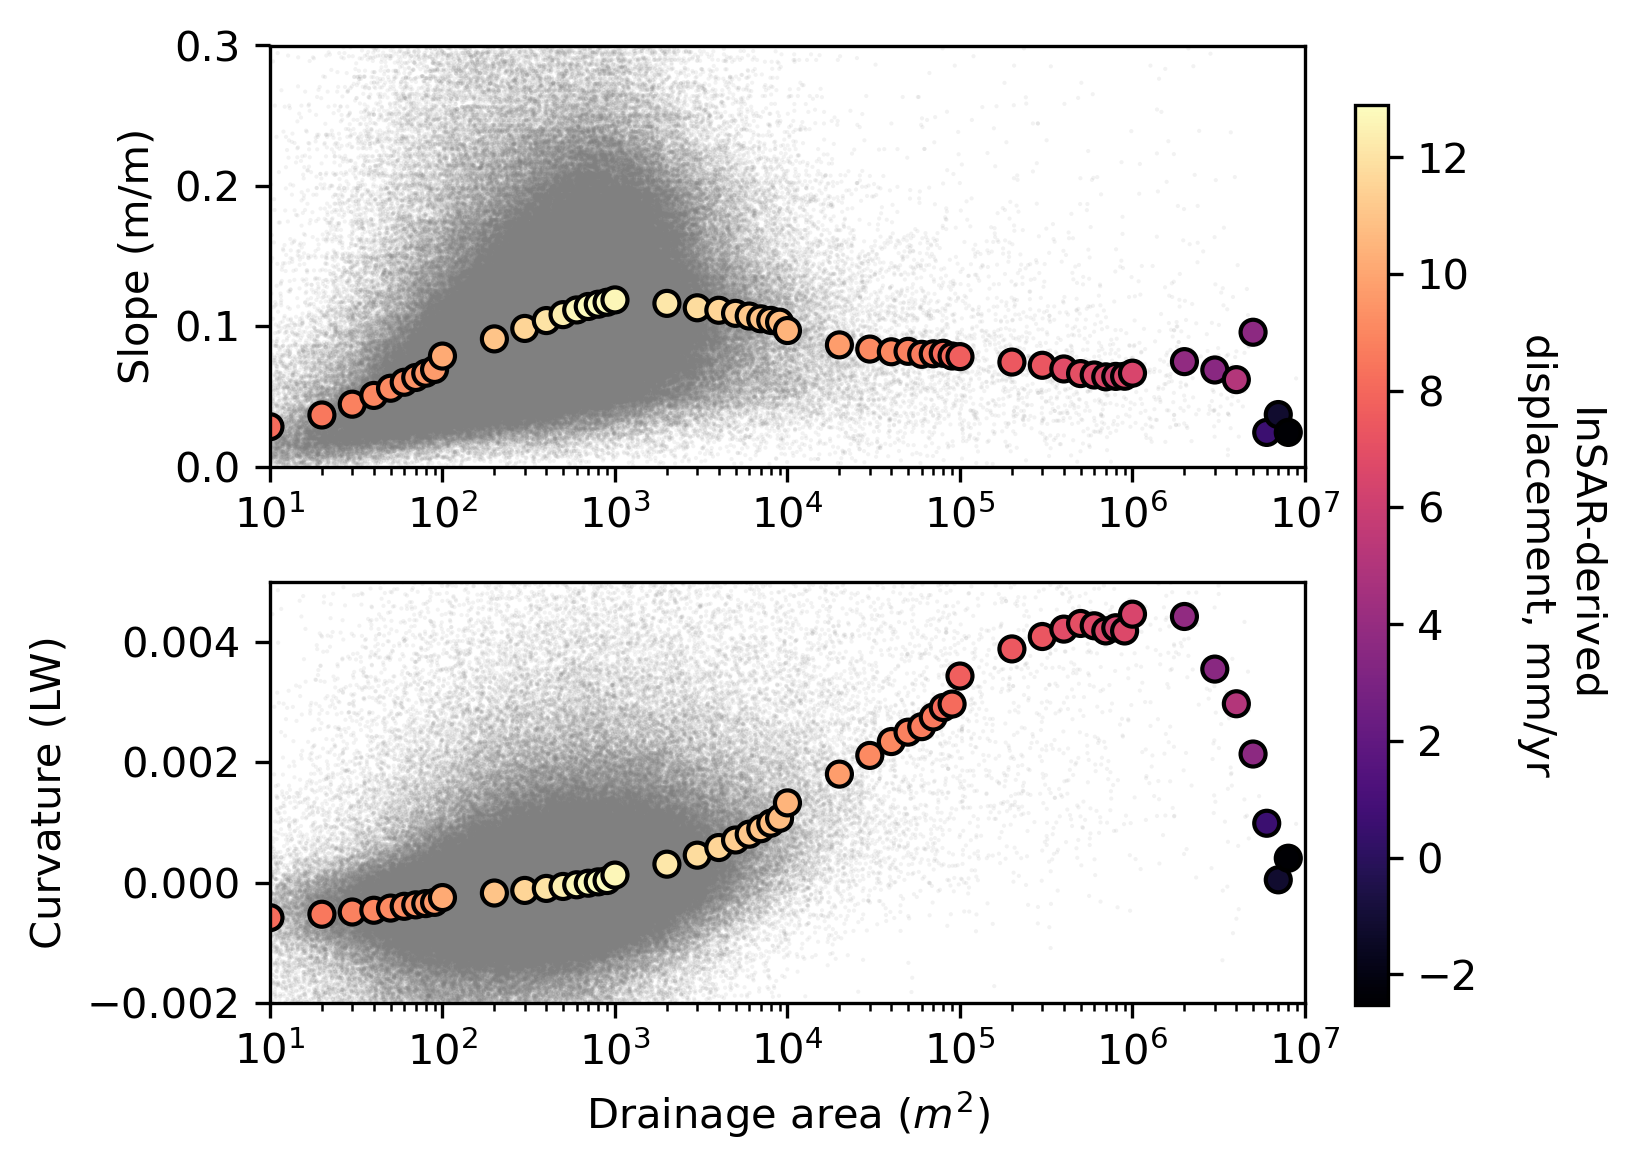

In [31]:
fig, ax = plt.subplots(2,1, figsize=(5.5,4), dpi=300)

# Plot all data as cloud

scatter = ax[0].scatter(df[drainage_column][::100], df[slope_column][::100],
                      c='gray',alpha=0.1, edgecolor='none')
scatter.set_sizes([1])

# Now binned data

im2 = ax[0].scatter(med_stat_sa.bin_edges[:-1],
                    med_stat_sa.statistic,
#                   c='w',  
                    c=(mean_stat_dd.statistic*1000),
                    cmap='magma',
                    edgecolor='k',
                    zorder=1
                   )

scatter2 = ax[1].scatter(df[drainage_column][::100], df[curv_column][::100],
                      c='gray',alpha=0.1, edgecolor='none')
scatter2.set_sizes([1])
im = ax[1].scatter(med_stat_ca.bin_edges[:-1],med_stat_ca.statistic,
#                  c='w',    
                   c=(mean_stat_dd.statistic*1000),
                   cmap='magma',
                   edgecolor='k'
                  )

#plt.axhline(0.0, color='k', linestyle='--', alpha=0.3)
ax[0].set_xlim((1E1, 1E7))
ax[0].set_ylim((0, 0.3))
ax[0].set_xscale('log')
ax[0].set_ylabel('Slope (m/m)')

ax[1].set_xlim((1E1, 1E7))
ax[1].set_ylim((-0.002, 0.005))
ax[1].set_xlabel('Drainage area ($m^{{{2}}}$)')
ax[1].set_ylabel('Curvature (LW)')
ax[1].set_xscale('log')

fig.tight_layout()

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.83, 0.15, 0.02, 0.75])
cb = fig.colorbar(im, cax=cbar_ax)
cb.set_label('InSAR-derived\ndisplacement, mm/yr', rotation=270, labelpad=30)
# plt.savefig('./figure_outputs/slope_curve_area_colored.png', bbox_inches="tight")
# plt.savefig('./figure_outputs/slope_curve_area_colored.pdf', bbox_inches="tight")


## Do slope area plot for only east-facing pixels

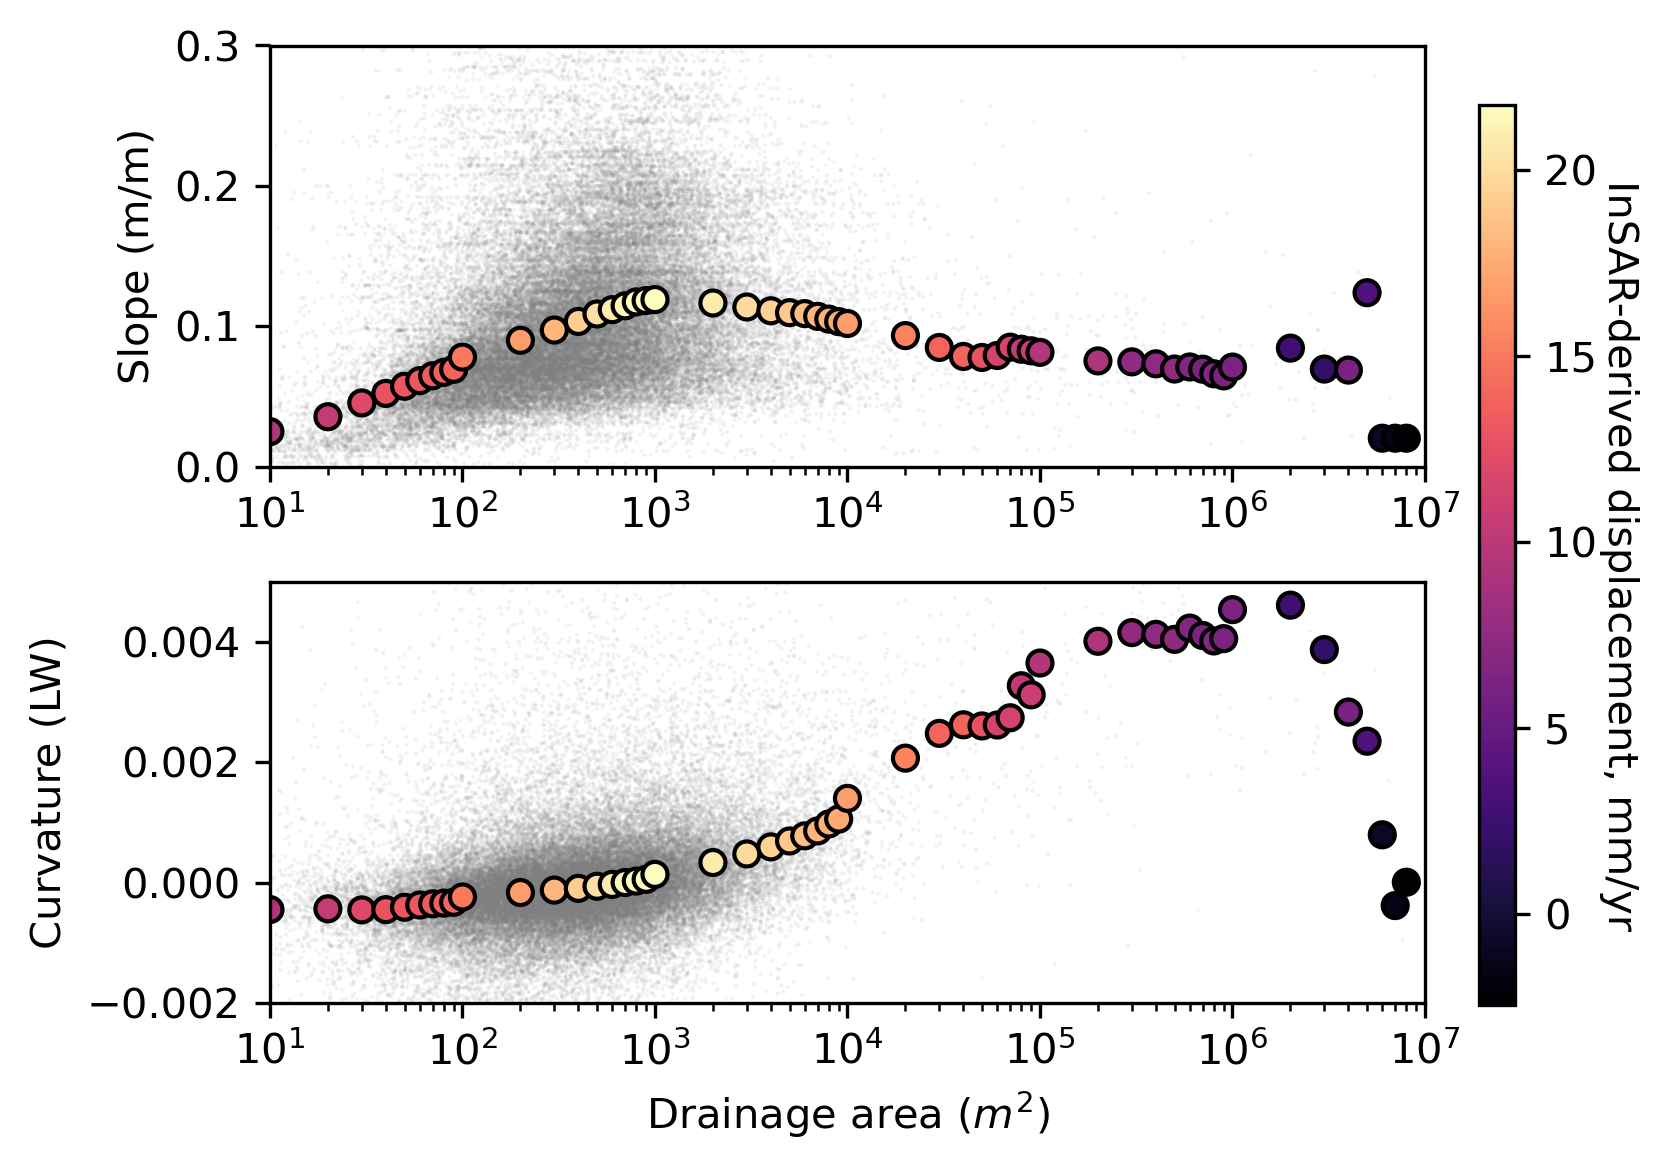

In [32]:
# Make bins and get binned stats

#Bins for area
a1=10.**(np.arange(1, 7)) 
a2 = np.arange(1,10,1)
bin_edges=np.outer(a1, a2).flatten()


east = df.loc[df['asp_card'] == 'E']

med_stat_sa = binned_statistic(east[drainage_column],east[slope_column],
                            statistic='median',
                            bins=bin_edges)

med_stat_ca = binned_statistic(east[drainage_column],east[curv_column],
                            statistic='median',
                            bins=bin_edges)

mean_stat_dd = binned_statistic(east[drainage_column],east['insar_displacement'],
                            statistic='mean', #####note
                            bins=bin_edges)

fig, ax = plt.subplots(2,1, figsize=(6,4), dpi=300)

# Plot all data as cloud

scatter = ax[0].scatter(east[drainage_column][::100], east[slope_column][::100],
                      c='gray',alpha=0.1, edgecolor='none')
scatter.set_sizes([1])

# Now binned data

im2 = ax[0].scatter(med_stat_sa.bin_edges[:-1],
                    med_stat_sa.statistic,
#                   c='w',  
                    c=(mean_stat_dd.statistic*1000),
                    cmap='magma',
                    edgecolor='k',
                    zorder=1
                   )

scatter2 = ax[1].scatter(east[drainage_column][::100], east[curv_column][::100],
                      c='gray',alpha=0.1, edgecolor='none')
scatter2.set_sizes([1])
im = ax[1].scatter(med_stat_ca.bin_edges[:-1],med_stat_ca.statistic,
#                  c='w',    
                   c=(mean_stat_dd.statistic*1000),
                   cmap='magma',
                   edgecolor='k'
                  )

#plt.axhline(0.0, color='k', linestyle='--', alpha=0.3)
ax[0].set_xlim((1E1, 1E7))
ax[0].set_ylim((0, 0.3))
ax[0].set_xscale('log')
ax[0].set_ylabel('Slope (m/m)')

ax[1].set_xlim((1E1, 1E7))
ax[1].set_ylim((-0.002, 0.005))
ax[1].set_xlabel('Drainage area ($m^{{{2}}}$)')
ax[1].set_ylabel('Curvature (LW)')
ax[1].set_xscale('log')

fig.tight_layout()

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.83, 0.15, 0.02, 0.75])
cb = fig.colorbar(im, cax=cbar_ax)
cb.set_label('InSAR-derived displacement, mm/yr', rotation=270, labelpad=10)
# plt.savefig('./figure_outputs/slope_curve_area_colored_east.png')
# plt.savefig('./figure_outputs/slope_curve_area_colored_east.pdf')

## Show how slope angle modulates drainage area-displacement trends

In [33]:
steep = df.loc[df['slope_15m'].between(0.1775, 0.2025)]
steep["steep_cat"] = "0.18-0.20"

vsteep = df.loc[df['slope_15m'].between(0.2975, .6525)]
vsteep["steep_cat"] = "0.30-0.65"

nosteep = df.loc[df['slope_15m'].between(0.0975, 0.1025)]
nosteep["steep_cat"] = "0.10"

jointplot_df = pd.concat([nosteep, steep, vsteep])

# For ease of interpretation just use east-facing pixels

jointplot_df = jointplot_df.loc[jointplot_df['asp_card'] == "E"]

/scratch/ipykernel_19078/4027113215.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  steep["steep_cat"] = "0.18-0.20"
/scratch/ipykernel_19078/4027113215.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vsteep["steep_cat"] = "0.30-0.65"
/scratch/ipykernel_19078/4027113215.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

In [34]:
mean_stat_dd1 = binned_statistic(nosteep[drainage_column],nosteep['insar_displacement'],
                            statistic='mean', #####note
                            bins=bin_edges)

mean_stat_dd2 = binned_statistic(steep[drainage_column],steep['insar_displacement'],
                            statistic='mean', #####note
                            bins=bin_edges)

mean_stat_dd3 = binned_statistic(vsteep[drainage_column],vsteep['insar_displacement'],
                            statistic='mean', #####note
                            bins=bin_edges)


std_stat_dd1 = binned_statistic(nosteep[drainage_column],nosteep['insar_displacement'],
                            statistic='std', #####note
                            bins=bin_edges)

std_stat_dd2 = binned_statistic(steep[drainage_column],steep['insar_displacement'],
                            statistic='std', #####note
                            bins=bin_edges)

std_stat_dd3 = binned_statistic(vsteep[drainage_column],vsteep['insar_displacement'],
                            statistic='std', #####note
                            bins=bin_edges)

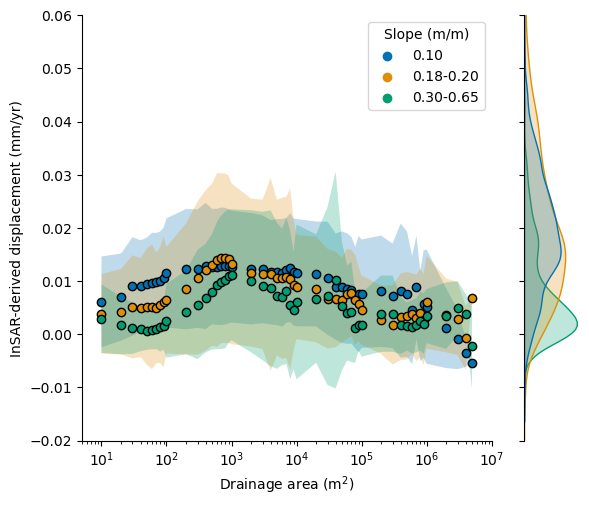

In [44]:
g = sns.jointplot(x='seward_hsp__dinf_area', y='insar_displacement', hue='steep_cat', data=jointplot_df[::100],
                  alpha=0, edgecolor='none', s=1,
                  palette="colorblind",
                  # kind='kde',

                 )
# g = joint grid
fig = g.figure
fig.get_axes() # list of axes 

ax = fig.get_axes()[0] #? 
ax.set_xscale('log')
ax.set_ylim((-0.02, 0.08)) 

pal = sns.color_palette("colorblind")

g.ax_marg_x.remove()

# im1 = ax.errorbar(mean_stat_dd1.bin_edges[:-1],
#                     mean_stat_dd1.statistic,
#                   yerr=std_stat_dd1.statistic,
#                   capsize=5,
#                   c=pal.as_hex()[0],  
#                     # c=(med_stat_dd.statistic*1000),
# #                    edgecolor='k',
#                     zorder=1
#                    )

# im2 = ax.errorbar(mean_stat_dd2.bin_edges[:-1],
#                     mean_stat_dd2.statistic,
#                   yerr=std_stat_dd2.statistic,
#                   capsize=5,
#                   c=pal.as_hex()[1],  
#                     # c=(med_stat_dd.statistic*1000),
# #                    edgecolor='k',
#                     zorder=1
#                    )

# im3 = ax.errorbar(mean_stat_dd3.bin_edges[:-1],
#                     mean_stat_dd3.statistic,
#                   yerr=std_stat_dd3.statistic,
#                   capsize=5,
#                   c=pal.as_hex()[2],  
#                     # c=(med_stat_dd.statistic*1000),
# #                    edgecolor='k',
#                     zorder=1
#                    )

im1 = ax.fill_between(mean_stat_dd1.bin_edges[:-1],
                      mean_stat_dd1.statistic-std_stat_dd1.statistic,
                      mean_stat_dd1.statistic+std_stat_dd1.statistic,
                     facecolor=pal.as_hex()[0],
                     alpha=0.25)

im2 = ax.fill_between(mean_stat_dd2.bin_edges[:-1],
                      mean_stat_dd2.statistic-std_stat_dd2.statistic,
                      mean_stat_dd2.statistic+std_stat_dd2.statistic,
                     facecolor=pal.as_hex()[1],
                     alpha=0.25)

im3 = ax.fill_between(mean_stat_dd3.bin_edges[:-1],
                      mean_stat_dd3.statistic-std_stat_dd3.statistic,
                      mean_stat_dd3.statistic+std_stat_dd3.statistic,
                     facecolor=pal.as_hex()[2],
                     alpha=0.25)

im1 = ax.scatter(mean_stat_dd1.bin_edges[:-1],
                    mean_stat_dd1.statistic,
                  c=pal.as_hex()[0],  
                    # c=(med_stat_dd.statistic*1000),
                    edgecolor='k',
                    zorder=2
                   )

im2 = ax.scatter(mean_stat_dd2.bin_edges[:-1],
                    mean_stat_dd2.statistic,
                  c=pal.as_hex()[1],  
                    # c=(med_stat_dd.statistic*1000),
                    edgecolor='k',
                    zorder=2
                   )

im3 = ax.scatter(mean_stat_dd3.bin_edges[:-1],
                    mean_stat_dd3.statistic,
                  c=pal.as_hex()[2],  
                    # c=(med_stat_dd.statistic*1000),
                    edgecolor='k',
                    zorder=2
                   )

plt.legend(title='Slope (m/m)')
ax.set_xlim((0.5E1, 1E7))
ax.set_ylim((-0.02, 0.06))
ax.set_xlabel('Drainage area (m$^{{{2}}}$)')
ax.set_ylabel('InSAR-derived displacement (mm/yr)')
fig.tight_layout()
plt.savefig('./figure_outputs/slope_trends.png', bbox_inches="tight")
# plt.savefig('./figure_outputs/slope_trends.pdf', bbox_inches="tight")

## Maybe there is cool N vs S

In [36]:
north = df.loc[df['asp_card'] == 'N']
south = df.loc[df['asp_card'] == 'S']


mean_stat_ddn = binned_statistic(north[drainage_column],north['insar_displacement'],
                            statistic='mean', #####note
                            bins=bin_edges)

mean_stat_dds = binned_statistic(south[drainage_column],south['insar_displacement'],
                            statistic='mean', #####note
                            bins=bin_edges)

std_stat_ddn = binned_statistic(north[drainage_column],north['insar_displacement'],
                            statistic='std', #####note
                            bins=bin_edges)

std_stat_dds = binned_statistic(south[drainage_column],south['insar_displacement'],
                            statistic='std', #####note
                            bins=bin_edges)

aspect_df = pd.concat([north, south])



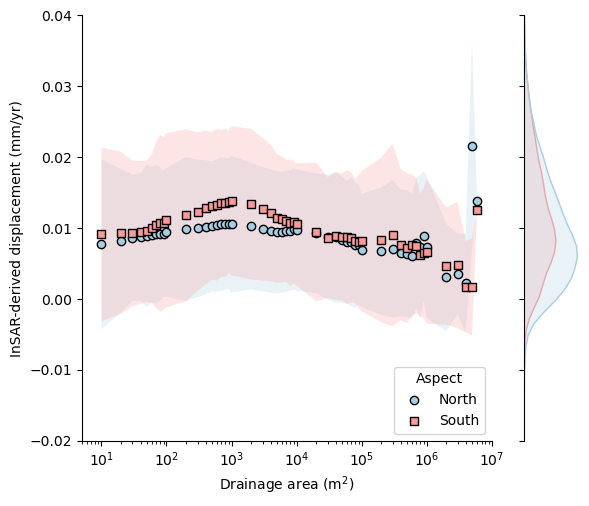

In [61]:
pal = sns.color_palette("Paired")

g = sns.jointplot(x='seward_hsp__dinf_area', y='insar_displacement', hue='asp_card', data=aspect_df[::100],
                  alpha=0, edgecolor='none', s=1,
                  # palette="Paired",
                  palette = [pal.as_hex()[0], pal.as_hex()[4]],
                  legend=False,
                  # kind='kde',

                 )

# g = joint grid
fig = g.figure
fig.get_axes() # list of axes 

ax = fig.get_axes()[0] #? 
ax.set_xscale('log')



g.ax_marg_x.remove()

im1 = ax.scatter(mean_stat_ddn.bin_edges[:-1],
                    mean_stat_ddn.statistic,
                  c=pal.as_hex()[0],  
                    # c=(med_stat_dd.statistic*1000),
                    edgecolor='k',
                 marker='o',
                    zorder=1,
                 label='North',
                   )

im2 = ax.scatter(mean_stat_dds.bin_edges[:-1],
                    mean_stat_dds.statistic,
                  c=pal.as_hex()[4],  
                    # c=(med_stat_dd.statistic*1000),
                    edgecolor='k',
                 marker='s',
                    zorder=1,
                 label="South",
                   )

im1 = ax.fill_between(mean_stat_ddn.bin_edges[:-1],
                      mean_stat_ddn.statistic-std_stat_ddn.statistic,
                      mean_stat_ddn.statistic+std_stat_ddn.statistic,
                     facecolor=pal.as_hex()[0],
                     alpha=0.25,
                     zorder=0)

im2 = ax.fill_between(mean_stat_dds.bin_edges[:-1],
                      mean_stat_dds.statistic-std_stat_dds.statistic,
                      mean_stat_dds.statistic+std_stat_dds.statistic,
                     facecolor=pal.as_hex()[4],
                     alpha=0.25,
                     zorder=0)

ax.legend(title='Aspect')

# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles=[handles[i] for i in [1,4]], labels=[labels[i] for i in [1,4]])

ax.set_xlim((0.5E1, 1E7))
ax.set_ylim((-0.02, 0.04))
ax.set_xlabel('Drainage area (m$^{{{2}}}$)')
ax.set_ylabel('InSAR-derived displacement (mm/yr)')

fig.tight_layout()
plt.savefig('./figure_outputs/aspect_trends.png', bbox_inches="tight")
# plt.savefig('./figure_outputs/aspect_trends.pdf', bbox_inches="tight")

# Show water track regime vs morphometry vs displacement in map view

In [38]:
from rasterio.mask import mask
curv = rasterio.open(os.path.join(basic_stack_dir, 'seward_hsp__tan_curv_LW.tif'))
curv_read = curv.read(1, masked=True)

extent=[curv.bounds[0], curv.bounds[2], curv.bounds[1], curv.bounds[3]]

slopeshade = rasterio.open((os.path.join(basic_stack_dir,'slope_15m.tif')), masked=True)

dinf = rasterio.open(os.path.join(basic_stack_dir, 'seward_hsp__dinf_area.tif'))
dinf_read=dinf.read(1, masked=True)

disp = rasterio.open(os.path.join(basic_stack_dir, 'insar_displacement.tif'))
disp_read = disp.read(1, masked=True)




In [39]:
rgb = rasterio.open('June_RGB.tif')

In [40]:


max_curve=0.001

curv_lo = np.ma.masked_where(curv_read < -0.001, curv_read)
curv_mask = np.ma.masked_where(curv_lo > max_curve, curv_lo)

max_dinf=1e4

dinf_lo = np.ma.masked_where(dinf_read < 5E2, dinf_read)
dinf_mask = np.ma.masked_where(dinf_lo > max_dinf, dinf_lo)

curv_dinf_masked = np.ma.masked_where((dinf_read > 1E4) & (dinf_read < 1e3), curv_mask)

# Did this so the lowest Blues wouldn't be white
import matplotlib.colors as colors

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('Blues')
new_Blues = truncate_colormap(cmap, 0.3, 1.0)

#https://stackoverflow.com/questions/18926031/how-to-extract-a-subset-of-a-colormap-as-a-new-colormap-in-matplotlib

(440000.0, 445000.0)

/dartfs-hpc/rc/home/1/f005dv1/.conda/envs/seward/lib/python3.10/site-packages/matplotlib/image.py:487: RuntimeWarning: overflow encountered in divide
  A_scaled /= ((a_max - a_min) / frac)


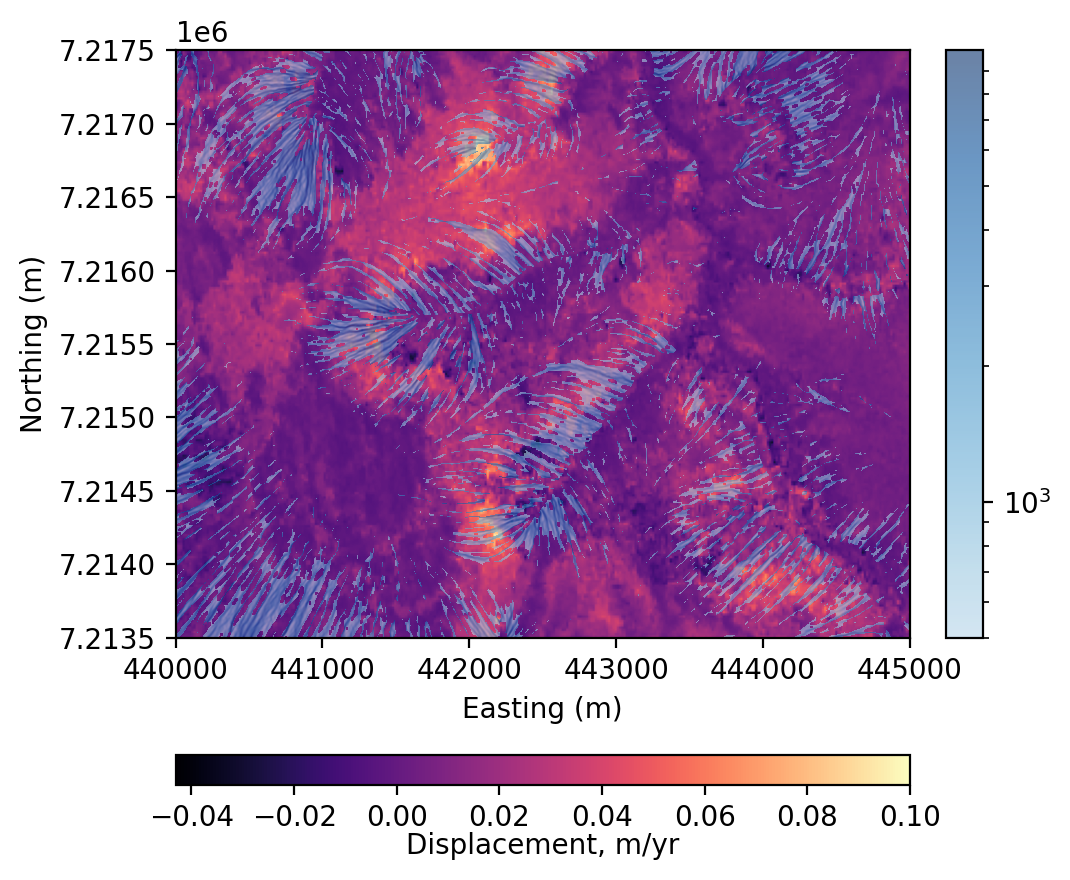

In [41]:
fig, ax = plt.subplots(figsize=(5, 4.5),dpi=200)

insar0 = ax.imshow(disp_read, cmap='magma', vmax=0.1, zorder=0) 
insar = rasterio.plot.show(disp, cmap='magma', vmax=0.1, ax=ax, zorder=1) 
im1 = ax.imshow(dinf_mask, extent=extent, norm=colors.LogNorm(), cmap=new_Blues, alpha=0.6, zorder=2)

divider = make_axes_locatable(ax)
# Add an axes to the right of the main axes.
cax = divider.append_axes("bottom", size="5%", pad="20%")
cb = fig.colorbar(insar0, cax=cax, orientation='horizontal')
cb.set_label('Displacement, m/yr', labelpad=0)

cax2 = divider.append_axes("right", size="5%", pad="5%")
cb2 = fig.colorbar(im1, cax=cax2, orientation='vertical')
# cb2.set_label('Drainage area (m$^{{{2}}}$)', labelpad=0)


ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')

fig.tight_layout()
ax.set_ylim((7.2135e6, 7.2175e6))
ax.set_xlim((440000, 445000))
# plt.savefig('./figure_outputs/disp_dinf.png', bbox_inches="tight")

In [42]:
disp_high = np.ma.masked_where(disp_read < 0.025, np.ones_like(disp_read))

Text(34.42457849035294, 0.5, 'Northing (m)')

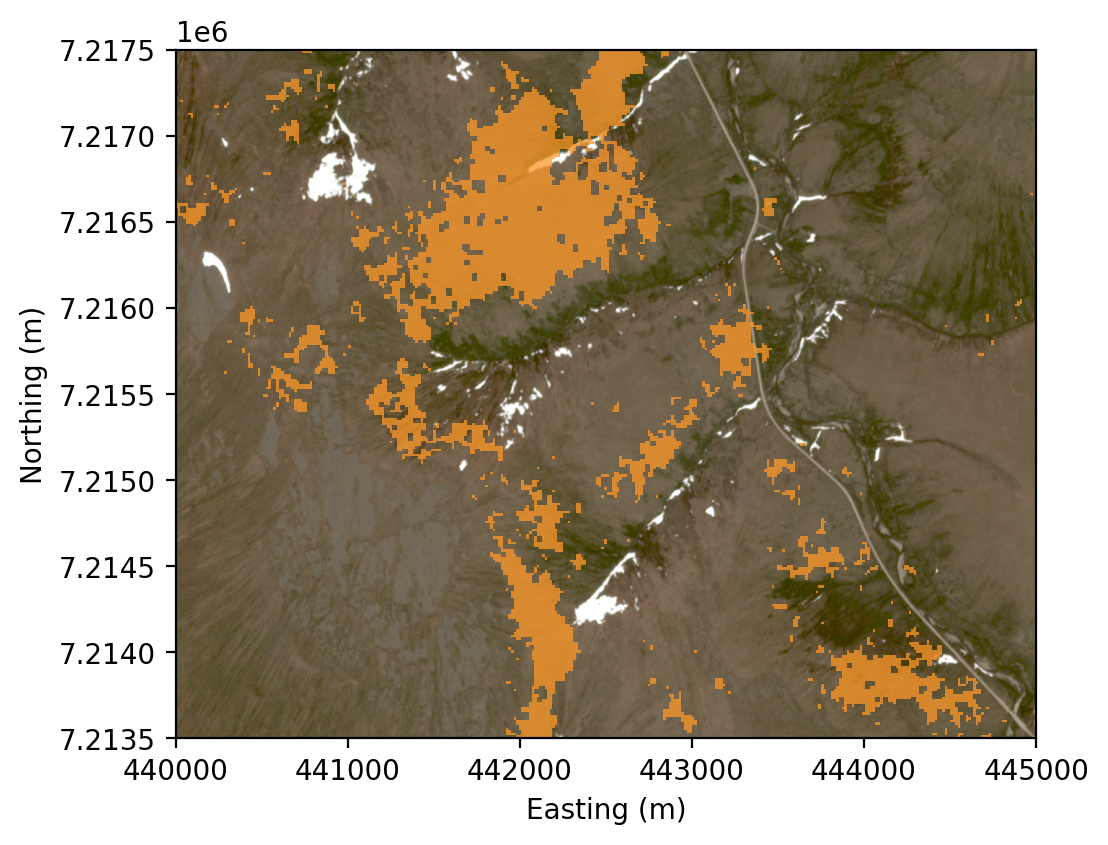

In [43]:
fig, ax = plt.subplots(figsize=(5, 4.5),dpi=200)


from rasterio.windows import Window

# ulx, uly = 5773695.0, 601200.0  
# width, height = 700, 500

# with rasterio.open('June_RGB.tif') as ds:
#     # Note - index takes coordinates in X,Y order 
#     #        and returns row, col (Y,X order)
#     row, col = ds.index(7.2175e6, 440000)
#     window = Window(row, col, 5000, 5000)
#     data = ds.read(1,  window=window)

rbg_im = rasterio.plot.show(rgb,
                           ax=ax,
                          zorder=0)

insar0 = ax.imshow(disp_high, extent=extent, cmap='YlOrBr',
                   #vmax=0.1,
                   alpha=0.75, zorder=1) 
# insar = rasterio.plot.show(disp, cmap='magma', vmax=0.1,
#                            alpha=0.9,
#                            ax=ax, zorder=1) 
# disp = ax.imshow(disp_high, extent=extent,
#                  cmap='magma',
#                  alpha=0.6,
#                  zorder=2)



# ax.set_xlabel('Easting (m)')
# ax.set_ylabel('Northing (m)')

fig.tight_layout()

cax = divider.append_axes("bottom", size="5%", pad="20%")
cb = fig.colorbar(insar0, cax=cax, orientation='horizontal')
cb.set_label('Displacement, m/yr', labelpad=0)
ax.set_ylim((7.2135e6, 7.2175e6))
ax.set_xlim((440000, 445000))
ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')

# plt.savefig('./figure_outputs/disp_rgb.png', bbox_inches="tight")